#### Parametric Matrix Models for Partial Differential Equation 

This work uses Parametric Matrix Models introcuded by Cook, Jammooa, et.al in https://www.nature.com/articles/s41467-025-61362-4, to solve the Black-Scholes partial differential equation. Parametric matrix models is a class of machine learning algorithms that utilize matrix equations to emulate physical systems, in contrast to the much researched neural networks that are based on the biology of neurons. 

Parametrix matrix models can learn the equations that govern a set of data, be they algebraic, integral or differential equations. This may have many applications in scientific computing. In addition, Cook, Jammo, et.al show in the paper that PMMs are universal function approximators. They also use PMMs on classical machine learning tasks such as image recognition, resulting in performance comparable to traditional methods. 

Parametric matrix models work by replacing operators in a given equation with parametrized, learnable matrices. Much of the mathematical and physical constraints in the underlying equations can be encoded in the PMM, as we will see later. 


The Black-Scholes equation is a partial differential equation used for pricing options. Accurately pricing financial derivatives like options, is a major challenge in finance. Options are contracts
that give the owner the right—but not the obligation—
to buy or sell an underlying asset at a certain price in
the future. Estimating the value of options is challenging
because financial markets are complex and influenced by
many unpredictable factors. It is also a problem of great
interest as 177.12 billion option contracts were traded in
2024 alone, according to the global trade organization
Futures Industry Association https://www.fia.org/fia/articles/etd-volume-december-2024. 

**The Black-Scholes equation** 

A European call option contains one underlying asset,
and gives the owner the right to buy the asset at a pre-determined strike price, K, at a specified time in the
future, T .


The Black-Scholes equation (BS equation) for such an option is given by:

$$
    \boxed{\frac{\partial C}{\partial t} = - \frac{1}{2}\sigma^2s^2 \frac{\partial^2C}{\partial s^2} - rs\frac{\partial C}{\partial s} + rC},
$$

where $C=C(s,t)$ represents the option price as a function of time, $t$, and the price of the underlying asset $s$. The volatility of the underlying asset, denoted by $\sigma$, describes how much the price of the asset fluctuates over time - higher volatility means that the price is more unpredictable. The risk-free rate, $r$, is a measure of how much money grows over time without any risk.
The BS equation has a terminal condition at time $t=T$ given by 
$$
    \boxed{C(s, T) = \max(s - K, 0)}. 
$$

Consider the operator on the right-hand side of the Black-Scholes equation, 
$$
    \mathcal{L} = - \frac{1}{2} \sigma^{2} s^{2} \frac{\partial^{2}}{\partial s^{2}} - r s \frac{\partial}{\partial s} + Ir. 
$$
We replace all three operators above with randomly parametrized matrices $A$ and $B$, and the identity $I$, respectively. After this we construct the matrix 

$$
    M(S) = -r\cdot s \cdot A - \sigma \cdot s^2\cdot B + rI. 
$$

We know have a fully parametrized matrix representation of $\mathcal{L}$. To solve the left hand  we use Forward Euler method to compute $\partial C / \partial t$


In the the case of a vanilla call option there exists a closed-form solution to the BS equation. 
$$
    C(S,t)=S\cdot \Phi(d_1)-Ke^{-r(T-t)}\cdot \Phi(d_2),
$$
where $\Phi(\cdot)$ denotes the cumulative distribution function of the standard normal distribution. The quantities $d_1$ and $d_2$ are given by:

$$
d_1 = \frac{\ln(\frac{S}{K}) + \left(r + \frac{1}{2} \sigma^2\right)(T - t)}{\sigma \sqrt{T - t}}, \quad
d_2 = d_1 - \sigma \sqrt{T - t}.
$$



We are now ready to actually implement our PMM with code. We will use pytorch to construct the class and for opitmizing. First we import the needed libraries. 

In [1]:
import numpy as np 
import torch 
from scipy.stats import norm 
import torch.optim as optim 
import torch.nn as nn
import matplotlib.pyplot as plt 


Now we define a PMM class that will contain all of our functionality. 

In [2]:
class PMM(nn.Module):
    def __init__(self, S_grid, N, dt):
        super().__init__()
        self.A_tmp = nn.Parameter(torch.randn(N * N, dtype=torch.float32) * 0.001)
        self.B_tmp = nn.Parameter(torch.randn(N * N, dtype=torch.float32) * 0.001)
        self.dt = dt
        self.N = N
        self.S_grid = S_grid
        
        # Precompute fixed grid components (never change during training)
        self.S_sq = (S_grid * S_grid).unsqueeze(1)
        self.S_vec = S_grid.unsqueeze(1)          
        self.I = torch.eye(N, device=S_grid.device)

    def M(self, sigma, r):
        #reshape matrices 
        A = self.A_tmp.view(self.N, self.N)
        B = self.B_tmp.view(self.N, self.N)
        
        # Symmetrize matrices
        A = (A + A.t()) / 2
        B = (B + B.t()) / 2
        
        # Ensure negative semi-definite structure
        B = -B.t() @ B
        
        # Construct components
        term1 = -r * self.S_vec * A
        term2 =  - sigma**2 * self.S_sq * B 
        term3 = self.I
        
        return term1 + term2 + term3

    def forward(self, data, sigma, r, M):
        return data + self.dt * M @ data # Matrix-vector mult

    def train(self, C_grid, sigma, r, n_epochs, lr):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        mse = nn.MSELoss()
        losses_list = []
        epochs_list = []
        N_t = C_grid.shape[1]
        M_best = None
        low_loss = 100.0
        for epoch in range(1, n_epochs + 1):
            optimizer.zero_grad()
            X = C_grid[:, 0].clone()
            loss = 0.0
            
            # Precompute M once per epoch
            M_mat = self.M(sigma, r)  

            for t in range(1, N_t):
                # Reuse precomputed M_mat for all time steps
                X = self.forward(X, sigma, r, M_mat)
         
               
                loss += mse(X, C_grid[:, t])
                
            if epoch%100 == 0 or epoch == 1:
                print(f"{epoch}/{n_epochs}, Loss is {loss}")
        
           
            if loss < low_loss: 
                low_loss = loss 
                M_best = M_mat 

            loss.backward()
            optimizer.step()
            losses_list.append(loss.item())
            epochs_list.append(epoch)
            
        return losses_list, epochs_list, M_best

    def predict_full(self, C0, sigma, r, N_t, M):
        C_pred = torch.zeros(self.N, N_t, device=C0.device)
        X = C0.clone()
        C_pred[:, 0] = X
        
        for t in range(1, N_t):
            X = self.forward(X, sigma, r, M)
            C_pred[:, t] = X
            
        return C_pred


The class has three arguments. S_grid has shape (N_s,) where N_s is the number of spatial (asset) points. $N^2$ is the size of an operator in the PMM, i.e. the number of trainable parameters per matrix used. dt is the time step used for predicting one step forwards. 

In the constructor we also define S_vec as a reshaped S_grid for mathematical ease later. We also compute the hadamard product of S_grid with itself to get all S_values squared. If you look at the operator $\mathcal{L}$ as defined above we need the S values squared. We also declare the identity matrix. 

In the method M we construct our complete operator consisting of A, B and I. The matrices A and B are symmetrized to enforce hermiticity as done in https://www.nature.com/articles/s41467-025-61362-4. We also ensure that B is negative semi-definite as B is to emulate the Laplacian.  

In the forward method we use a simple Forward Euler step to predict the price at step t + dt. 

The train method uses the Adam optimizer and mean-square error loss. 

Finally, the method predict_full is used for prediction after training is complete. 

We will train our model on values provided by the closed-form formula for the Black-Scholes equation. 

In [3]:

def generate_bs_grid(N_s, S_max, T, sigma, r, K, dt):
    """
    Generate Black–Scholes call-option prices on an (S, t) grid.

    Arguments:
        - N_s (int): Number of asset-price points.
        - S_max (float): Maximum asset price.
        - T (float): Time to maturity.
        - sigma (float): Volatility.
        - r (float): Risk-free interest rate.
        - K (float): Strike price.
        - dt (float): Time-step size.

    Returns:
        - S_grid (torch.Tensor): Asset-price grid, shape (N_s,).
        - t_grid (torch.Tensor): Time grid, shape (N_t,).
        - C (torch.Tensor): Option prices, shape (N_s, N_t).
    """
    # Time grid
    N_t = int(T / dt) + 1
    t_grid = torch.linspace(0.0, T, N_t)

    # Asset-price grid
    S_grid = torch.linspace(0.0, S_max, N_s)

    # Pre-allocate output
    C = torch.zeros(N_s, N_t)

 
    # Compute grid values
    for j, t in enumerate(t_grid):
        tau = T - t
        sqrt_tau = torch.sqrt(tau) if tau > 0 else torch.tensor(0.0)

        # Prevent division by zero
        denom = sigma * sqrt_tau + 1e-12
        d1 = (torch.log(S_grid / K) + (r + 0.5 * sigma**2) * tau) / denom
        d2 = d1 - sigma * sqrt_tau

        C_t = S_grid * norm.cdf(d1) - K * torch.exp(-r * tau) * norm.cdf(d2)
        C[:, j] = C_t

    return S_grid, t_grid, C

The generate_bs_grid function calculates the option prices, and returns the S_grid, t_grid and C (option prices). 

We now define the financial parameters used in our model. 

In [4]:
# parameters
N_s    = 50   # number of asset‐price points
S_max  = 20.0     # maximum asset price
T      = 1.0      # maturity
sigma  = 0.2      # volatility
r      = 0.05     # risk‐free rate
K      = 3.0      # strike

# time discretization
dt     = 0.01


For computational efficiency we use model order reduction resulting in fewer parameters to optimize. We there use the SVD provided by pytorch. 

In [5]:

S_grid, t_grid, C_grid = generate_bs_grid(N_s, S_max, T, sigma, r, K, dt)

#initialize parameter
N = 5
epochs = 3000
learning_rate = 0.01


#svd
# Perform Singular Value Decomposition (SVD) for dimensionality reduction or basis transformation.
# X_train.T is used because SVD typically operates on a matrix where columns are observations.
U, S, Vt = np.linalg.svd(C_grid)
print(f"Shape of u (left singular vectors): {np.shape(U)}")

# Select the first 'n' principal components (or basis vectors) from 'u'.
# This creates a projection matrix 'P'.
P = U[:,:N]

#Project C and S to the subspace spanned by columns of P. 
C_projected = P.T @ C_grid
S_projected = P.T @ S_grid


Shape of u (left singular vectors): torch.Size([50, 50])


/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_94372/1754627608.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_t = S_grid * norm.cdf(d1) - K * torch.exp(-r * tau) * norm.cdf(d2)


Here we project C and the S_grid using the projection matrix P, that essentially creates a reduced basis for asset dimension. 

We are now ready to train our model. 

1/3000, Loss is 66134.1875
100/3000, Loss is 0.6242871284484863
200/3000, Loss is 0.01856832578778267
300/3000, Loss is 0.018438544124364853
400/3000, Loss is 0.018299147486686707
500/3000, Loss is 0.01813909038901329
600/3000, Loss is 0.017959602177143097
700/3000, Loss is 0.017757616937160492
800/3000, Loss is 0.01754092425107956
900/3000, Loss is 0.0173029787838459
1000/3000, Loss is 0.017055081203579903
1100/3000, Loss is 0.016785597428679466
1200/3000, Loss is 0.016502298414707184
1300/3000, Loss is 0.01620747148990631
1400/3000, Loss is 0.01589556597173214
1500/3000, Loss is 0.015568994916975498
1600/3000, Loss is 0.015232999809086323
1700/3000, Loss is 0.014877581968903542
1800/3000, Loss is 0.01451774500310421
1900/3000, Loss is 0.0141436867415905
2000/3000, Loss is 0.013759045861661434
2100/3000, Loss is 0.013364654965698719
2200/3000, Loss is 0.012963108718395233
2300/3000, Loss is 0.012548904865980148
2400/3000, Loss is 0.012132539413869381
2500/3000, Loss is 0.0117095829918

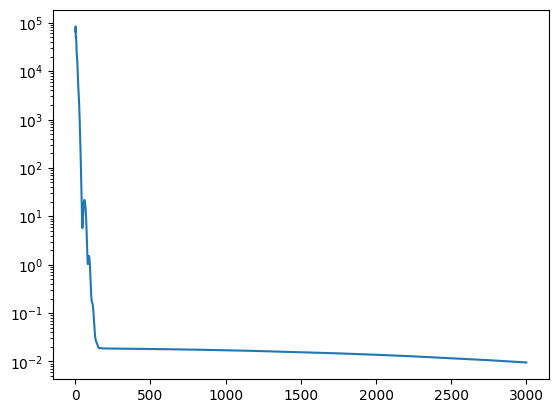

In [6]:
model = PMM(S_projected, N, dt)
losses_list, epochs_list, matrix = model.train(C_projected, sigma=0.2, r=0.05, n_epochs=epochs, lr=learning_rate)



plt.plot(epochs_list, losses_list)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()



We see that the loss drops significantly the first 100 epochs, and then experience little to no decrease, before it decreases more at the end. This hints that the loss has not converged. Why does it have this loss shape? 

After training we use the model to predict option prices from the initial condition. 

In [7]:
#After training, predict full grid:
C0 = C_projected[:, 0]
N_t = C_grid.size(1)
C_grid_pred_projected = model.predict_full(C0, sigma=0.2, r=0.05, N_t=N_t, M=matrix).detach().numpy()


C_grid_pred = P @ C_grid_pred_projected #reconstruct from projected space to full space 

/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_94372/935360528.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_grid_pred = P @ C_grid_pred_projected #reconstruct from projected space to full space


Finally, we plot the analytical result against the model prediction. 

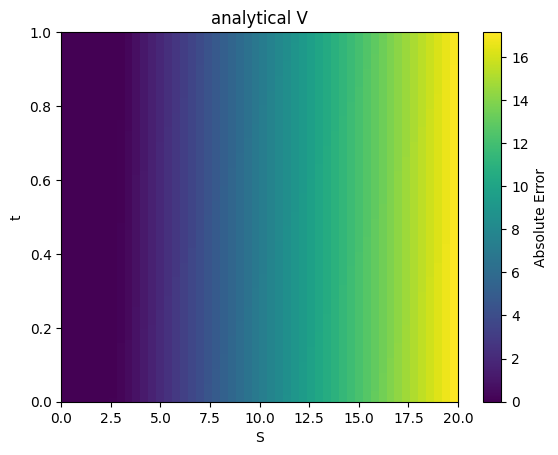

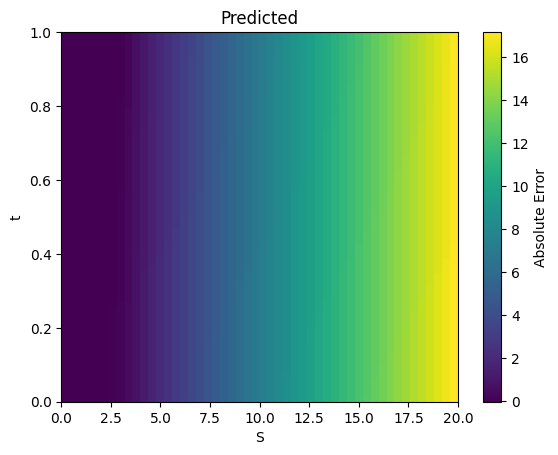

Maximum absolute error across all times: 0.0189
Mean absolute error across all times: 0.0021


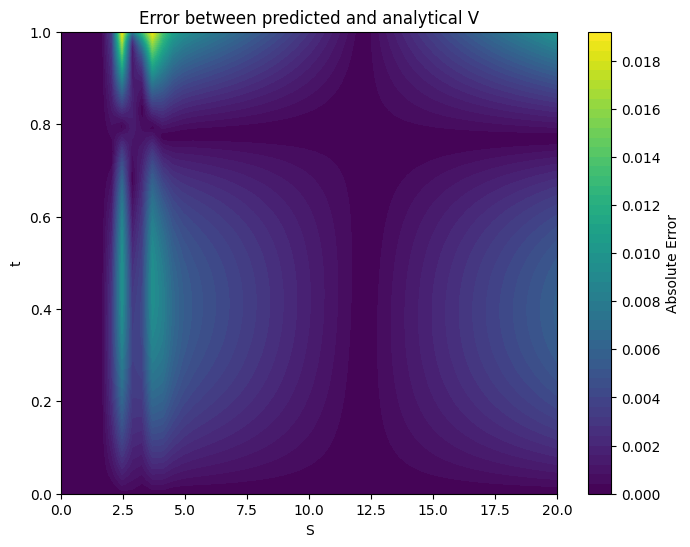

In [8]:

#turn to numpy arrays and transpose for plotting
C_grid = C_grid.detach().numpy()
C_grid = C_grid.T
C_grid_pred = C_grid_pred.detach().numpy()
C_grid_pred = C_grid_pred.T



error = np.abs(C_grid_pred - C_grid)
plt.imshow(C_grid, extent=[0, S_max, 0, T], aspect='auto', origin='lower')
plt.colorbar(label='Absolute Error')
plt.xlabel('S'); plt.ylabel('t'); plt.title('analytical V')
plt.show()

plt.imshow(C_grid_pred, extent=[0, S_max, 0, T], aspect='auto', origin='lower')
plt.colorbar(label='Absolute Error')
plt.xlabel('S'); plt.ylabel('t'); plt.title('Predicted')
plt.show()

abs_error = np.abs(C_grid - C_grid_pred)
# Print error statistics
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"Maximum absolute error across all times: {max_error:.4f}")
print(f"Mean absolute error across all times: {mean_error:.4f}")


# Plot using contourf
plt.figure(figsize=(8, 6))
contour = plt.contourf(S_grid, t_grid, abs_error, levels=50, cmap='viridis')
plt.colorbar(contour, label='Absolute Error')
plt.xlabel('S')
plt.ylabel('t')
plt.title('Error between predicted and analytical V')
plt.show()


The PMM generally performs well, but has a big increase in error close to the kink at (S = K, t=T). This is present other machine learning methods as well, as we shall see later when comparing the PMM to PINNs and a traditional feed forward Neural Network.

##### Comparison with PINNs and a traditional neural network

We now compare the PMM model with a previously trained PINN model. Check out the repo: https://github.uio.no/fredrink/FYS5429 for more informaiton on how it was trained. 

In [9]:
import torch.nn.init as init
class ModelPinn(nn.Module):
    """
    A fully connected feed-forward neural network designed for solving PDEs using 
    Physics-Informed Neural Networks (PINNs). 

    This model allows customization of the input size, the number and size of hidden layers, and the activation function.
    """
    def __init__(self, num_inputs, hidden_layers, activation_function):
        """
        Initializes the fully connected neural network.

        Parameters:
            - num_inputs                (int): Number of input features (e.g., spatial and temporal coordinates).
            - hidden_layers     (list of int): List specifying the number of neurons in each hidden layer.
            - activation_function (nn.Module): Activation function to apply after each hidden layer.
        """
        super(ModelPinn, self).__init__()  # Initialize the parent class

        self.activation = activation_function
        
        # Build the network layer by layer
        layers = [nn.Linear(num_inputs, hidden_layers[0]), self.activation]
        for i in range(1, len(hidden_layers)):
            layers += [nn.Linear(hidden_layers[i-1], hidden_layers[i]), self.activation]
        layers.append(nn.Linear(hidden_layers[-1], 1))


        # Create model and move it to the appropriate device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = nn.Sequential(*layers).to(device)

        # Initialize weights using Xavier initialization 
        self.model.apply(self._init_weights)

       

    def _init_weights(self, m):
        """
        Applies Xavier unifeorm initialization to the weights of linear layers,
        and sets their biases to zero.

        Parameters:
            - m (nn.Module): A layer in the model passed during model.apply().
        """
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight, gain=init.calculate_gain('tanh'))
            if m.bias is not None:
                init.zeros_(m.bias)  # Set bias to zero
        
     
    
    def forward(self, x):
        """
        Performs the forward pass of the neural network.

        Parameters:
            - x (torch.Tensor): Input tensor of shape (batch_size, num_inputs),
                                typically representing spatial and/or temporal coordinates.

        Returns:
            - torch.Tensor:     Output tensor containing the model's predictions.
        """       
        # Pass input through the network
        return self.model(x)

We need a function to prepare the input data for the PINN model. 

In [10]:
def ready_input_PINN(S_meshes, t_mesh, S_max, total_time):
    """
    Function that takes in meshes and returns torch tensor for model input
    
    """

    coords = np.column_stack([S.ravel() for S in S_meshes] + [t_mesh.ravel()])
    inp = torch.tensor(coords, dtype=torch.float32)
    # Normalize spatial dims
    spatial = [2.0 * (inp[:, i:i+1] / S_max) - 1.0 for i in range(len(S_meshes))]
    # Normalize time (tau) to [-1,1]
    tau = (total_time - inp[:, -1:]) / total_time
    taun = 2.0 * tau - 1.0


    return torch.cat(spatial + [taun], dim=1)

We create the model and put in eval mode. 

In [11]:
model_pinn = ModelPinn(num_inputs=2, hidden_layers=[32, 32, 32, 32], activation_function=nn.Tanh())
model_pinn.load_state_dict(torch.load("PINN_Models/1D.pth", map_location=torch.device('cpu')))
model_pinn.eval()  # Set model to evaluation mode

ModelPinn(
  (activation): Tanh()
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

It is time to construct the input data and predict with the model. 

In [12]:
#Create data for prediction 
t_vals  = torch.linspace(0, T, 101)
s1_vals = torch.linspace(0, S_max, 50)



tg, s1g = np.meshgrid(t_vals, s1_vals,indexing='ij') 
S_meshes = [s1g]
input_tensor = ready_input_PINN(S_meshes, t_mesh=tg, S_max = 20, total_time=T)


with torch.no_grad():
    model_pinn.to(C_grid.device)  # Ensure model is on the same device as C_pred_original
    y_pred = model_pinn(input_tensor).cpu().numpy()  # shape: (N_flat * N_t, 1)
# Reshape back to Monte Carlo grid shape
C_pred_pinn = y_pred.reshape(*C_grid.shape)  # (N_t, N_s1, N_s2)    


abs_error = np.abs(C_pred_pinn - C_grid)
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"PINN Maximum absolute error: {max_error:.6f}")
print(f"PINN Mean absolute error: {mean_error:.6f}")

PINN Maximum absolute error: 0.009642
PINN Mean absolute error: 0.001036


We now plot the PINN solution as well. 

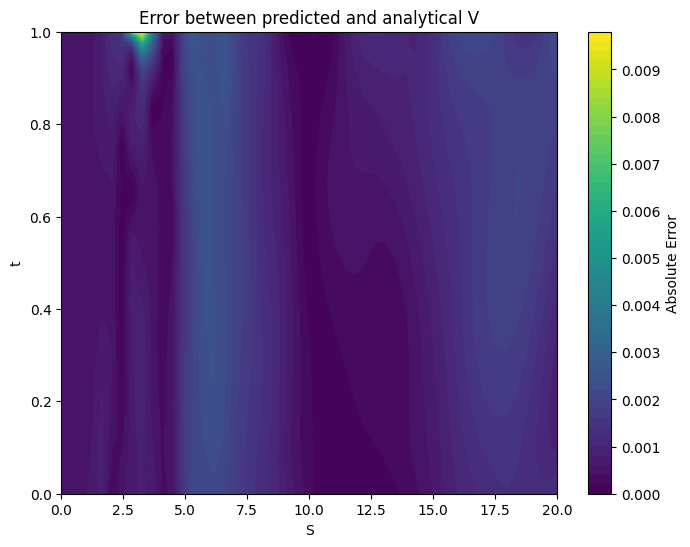

In [13]:
# Plot using contourf

plt.figure(figsize=(8, 6))
contour = plt.contourf(s1g, tg, abs_error, levels=50, cmap='viridis')
plt.colorbar(contour, label='Absolute Error')
plt.xlabel('S')
plt.ylabel('t')
plt.title('Error between predicted and analytical V')
plt.show()


We again see that the model struggles the most at the kink. 

**Traditional Neural Network**

We define the class used for the traditional neural network. The class is generalized to multiple asset which will come in handy later when we solve the multidimensional Black-Scholes equation. 

In [14]:
import torch.nn.init as init

class Model(nn.Module):
    """
    A fully connected feed-forward neural network designed for solving Black-Scholes equation
    """
    def __init__(self, num_inputs, hidden_layers, activation_function=nn.Tanh()):
        """
        Initializes the fully connected neural network.

        Parameters:
            - num_inputs                (int): Number of input features (e.g., spatial and temporal coordinates).
            - hidden_layers     (list of int): List specifying the number of neurons in each hidden layer.
            - activation_function (nn.Module): Activation function to apply after each hidden layer.
        """
        super(Model, self).__init__()  # Initialize the parent class

        self.activation = activation_function
        
        # Build the network layer by layer
        layers = [nn.Linear(num_inputs, hidden_layers[0]), self.activation]
        for i in range(1, len(hidden_layers)):
            layers += [nn.Linear(hidden_layers[i-1], hidden_layers[i]), self.activation]
        layers.append(nn.Linear(hidden_layers[-1], 1))


        # Create model and move it to the appropriate device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = nn.Sequential(*layers).to(device)

        # Initialize weights using Xavier initialization 
        self.model.apply(self._init_weights)

       

    def _init_weights(self, m):
        """
        Applies Xavier uniform initialization to the weights
        and sets their biases to zero.

        Parameters:
            - m (nn.Module): A layer in the model to initialize.
        """
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight, gain=init.calculate_gain('tanh'))
            if m.bias is not None:
                init.zeros_(m.bias)  # Set bias to zero
        
     
    
    def forward(self, x):
        """
        Performs the forward pass of the neural network.

        Parameters:
            - x (torch.Tensor): Input tensor of shape (batch_size, num_inputs),
                                typically representing spatial and/or temporal coordinates.

        Returns:
            - torch.Tensor:     Output tensor containing the model's predictions.
        """       
        # Pass input through the network
        return self.model(x)
    

class TraditionalSolverBasket:
    def __init__(self, model, S_max, T, K, r, sigma, weights):
        """
        Generalized solver for N-dimensional basket options
        Args:
            model: Neural network model (d+1 inputs: d assets + time)
            S_list: List of 1D tensors for each asset price grid
            t_grid: 1D tensor of time points
            C_grid: (N_t, *N_s) tensor of option prices
            S_max: Maximum asset price (for normalization)
            T: Maturity time
            K: Strike price
            r: Risk-free rate
            sigma: Volatilities for each asset
            weights: Weighting for each asset in the basket
        """
        self.model = model
        self.S_max = S_max
        self.T = T
        self.K = K
        self.r = r
        self.sigma = sigma
        self.weights = weights
        self.d = len(sigma)  # Number of assets
        self.device = next(model.parameters()).device
        
   
        
    
    def training_step(self, X_data, y_data, optimizer):
       
        predictions = self.model(X_data)

        loss = nn.MSELoss()(predictions, y_data)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    def training_cycle(self, X_data, y_data, n_epochs=1000):
      
        optimizer = optim.Adam(self.model.parameters(), lr=0.005)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=50, verbose=True
        )
        
        losses = []
        best_loss = float('inf')
        best_model_state = None
        
        self.model.train()
        for epoch in range(n_epochs):
            epoch_loss = 0.0
            loss = self.training_step(X_data, y_data, optimizer)
            epoch_loss += loss
            
          
            losses.append(epoch_loss)
            scheduler.step(epoch_loss)
            
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_state = self.model.state_dict()
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")
        
        # Load best model
        if best_model_state:
            self.model.load_state_dict(best_model_state)
        
        return losses
   

The next method is used for predicting. 

In [15]:
def predict_full(model, X_data, C_grid_shape):
    """
    Predicts the full option price grid using the trained model.
    
    Args:
        model: Trained neural network model.
        X_data: Tensor of shape (N_total, d+1) containing (t, S1, ..., Sd) points.
        C_grid_shape: Shape of the original Monte Carlo grid, e.g., (N_t, N_s1, N_s2, ...)
        
    Returns:
        C_pred: Predicted option prices reshaped to the original grid shape.
    """
    model.eval()
    with torch.no_grad():
        y_pred = model(X_data).cpu().numpy()  # shape: (N_flat * N_t, 1)
    
    # Reshape back to C_grid shape
    C_pred = y_pred.reshape(*C_grid_shape)
    return C_pred


below is the code for training and predicting with this machine learning setup. 

In [55]:
N_s = 50 #Number of asset-price points 
N_t = 101 #Number of time points 
S_max = 20.0 #Maximum asset price
T = 1.0 #Time to maturity
sigma = torch.tensor([0.2]) #Volatility
r = 0.05 #Risk-free interest rate
K = 3.0 #Strike price
dt = T / (N_t - 1) #Time-step size
d = 1 #Number of assets




S_grid, t_grid, C_grid_train = generate_bs_grid(N_s, S_max, T, sigma, r, K, dt)



# Generate full 2D mesh
Tg, S1g = torch.meshgrid(t_grid, S_grid, indexing='ij')

# Stack into (N_t*N_s1, 2)
X_data = torch.stack([Tg, S1g], dim=-1).reshape(-1, 2)



# Create the model
model_tnn = Model(num_inputs=2, hidden_layers=[32, 32, 32, 32], activation_function=nn.Tanh())
# Initialize the solver with the model and parameters
solver = TraditionalSolverBasket(model_tnn, S_max, T, K, r, sigma, weights=[1.0])   
# Prepare the training data 
y_data = C_grid_train.reshape(-1, 1).to(solver.device)
# Train the model
losses = solver.training_cycle(X_data, y_data, n_epochs=3000)       





#new data for prediction 
N_s = 101 #Number of asset-price points 
N_t = 201 #Number of time points 
dt = T / (N_t - 1) #Time-step size

_, _, C_grid = generate_bs_grid(N_s, S_max, T, sigma, r, K, dt)
# Flatten the Monte Carlo grid
N_t, N_s1 = C_grid.shape
N_flat = N_s1 
C_flat = C_grid.reshape(N_t, N_flat).T  # (N_flat, N_t)
# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t)
s1_vals = torch.linspace(0, S_max, N_s1)


# Generate full mesh
Tg, S1g = torch.meshgrid(t_vals, s1_vals, indexing='ij')

# Stack into (N_t*N_s1,2)
X_data_pred = torch.stack([Tg, S1g], dim=-1).reshape(-1, 2)






#predict on training data
C_pred_train = predict_full(model_tnn, X_data, C_grid_train.shape)     
# Print error statistics
abs_error = np.abs(C_pred_train - C_grid_train.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on training data: {max_error:.6f}")
print(f"NN Mean absolute error on training data: {mean_error:.6f}")



#predict on new data
C_pred = predict_full(model_tnn, X_data_pred, C_grid.shape)  
# Print error statistics
abs_error = np.abs(C_pred - C_grid.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on new data: {max_error:.6f}")
print(f"NN Mean absolute error on new data: {mean_error:.6f}")




/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_94372/1754627608.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_t = S_grid * norm.cdf(d1) - K * torch.exp(-r * tau) * norm.cdf(d2)


Epoch 1/3000, Loss: 60.800583
Epoch 11/3000, Loss: 28.503010
Epoch 21/3000, Loss: 21.734343
Epoch 31/3000, Loss: 8.916206
Epoch 41/3000, Loss: 2.658616
Epoch 51/3000, Loss: 1.349677
Epoch 61/3000, Loss: 0.762165
Epoch 71/3000, Loss: 0.427845
Epoch 81/3000, Loss: 0.282296
Epoch 91/3000, Loss: 0.203577
Epoch 101/3000, Loss: 0.153277
Epoch 111/3000, Loss: 0.135861
Epoch 121/3000, Loss: 0.118795
Epoch 131/3000, Loss: 0.097459
Epoch 141/3000, Loss: 0.089351
Epoch 151/3000, Loss: 0.086680
Epoch 161/3000, Loss: 0.076644
Epoch 171/3000, Loss: 0.072510
Epoch 181/3000, Loss: 0.069330
Epoch 191/3000, Loss: 0.066275
Epoch 201/3000, Loss: 0.064247
Epoch 211/3000, Loss: 0.216006
Epoch 221/3000, Loss: 0.060500
Epoch 231/3000, Loss: 0.109973
Epoch 241/3000, Loss: 0.061438
Epoch 251/3000, Loss: 0.058126
Epoch 261/3000, Loss: 0.056681
Epoch 271/3000, Loss: 0.053804
Epoch 281/3000, Loss: 0.052131
Epoch 291/3000, Loss: 0.051020
Epoch 301/3000, Loss: 0.049887
Epoch 311/3000, Loss: 0.048913
Epoch 321/3000, 

We now plot the absolute error as before. 

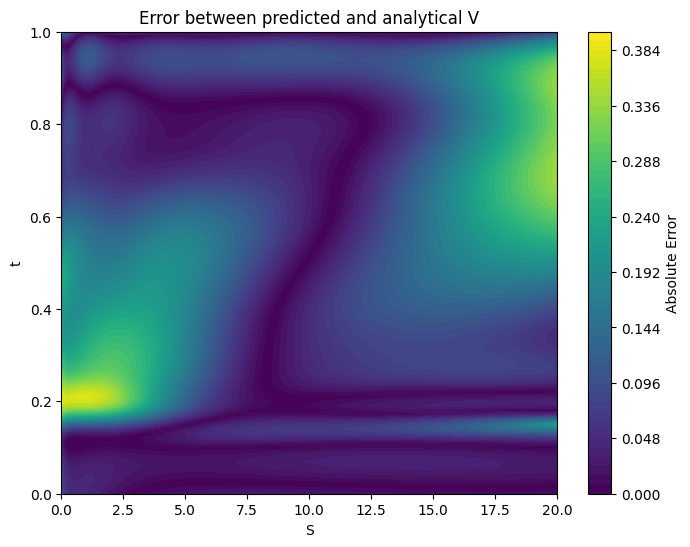

In [56]:
# Plot using contourf

plt.figure(figsize=(8, 6))
contour = plt.contourf(S1g, Tg, abs_error, levels=50, cmap='viridis')
plt.colorbar(contour, label='Absolute Error')
plt.xlabel('S')
plt.ylabel('t')
plt.title('Error between predicted and analytical V')
plt.show()

**Important Question** 
Why doesn't this model experience errors at the kink $S=K$ and time $t=T$ as the model in the BlackScholesPINN jupyter file and as the PINN models do? 

##### 1D equation model comparison

We have now tested the performance of three different machine learning models on the one-dimensional Black-Scholes equation. 

Our results were as follows: 

**PMM**
- Maximum absolute error across all times: 0.0191
- Mean absolute error across all times: 0.0021

**Traditional Neural Network**
- Maximum absolute error on training data: 0.364426
- Mean absolute error on training data: 0.125635
- Maximum absolute error on new data: 0.476523
- Mean absolute error on new data: 0.099000

**PINN model**
- PINN Maximum absolute error: 0.009642
- PINN Mean absolute error: 0.001036



#### The multidimensional Black-Scholes equation 

We now move on to the multidimensional Black-Scholes equation. This equation is given by 
$$
\frac{\partial C}{\partial t} = - \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d \rho_{ij} \sigma_i \sigma_j S_i S_j \frac{\partial^2 C}{\partial S_i \partial S_j} - \sum_{i=1}^d r S_i \frac{\partial C}{\partial S_i} + r C 
$$



Here the operator we will replace is given by 

$$
\mathcal{L} = - \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d \rho_{ij} \sigma_i \sigma_j S_i S_j \frac{\partial^2 }{\partial S_i \partial S_j} - \sum_{i=1}^d r S_i \frac{\partial }{\partial S_i} + rI. 
$$

Each double derivative in the double sum will be parametrized with its own matrix, the same applies to the derivative in the single sum. Again we will not parametrize $I$.


In our training method we also return all the parametrized matrices (after training is complete). This is done because I have experienced with if the model can be trained on one set of financial parameters, but still generalize to different ones. 
The main idea has been to project the parameters together with the vectors and the matrices, and then project them back to the full space. After this is done I thought to multiply the matrices with a suitable factor that corresponds to the new financial parameter. So for instance if the model is trained with $\sigma_i = 0.2$ and then we set $\sigma_i = 0.4$ we can multiply the previous second derivative matrices with $2$ to get the matrices to apply to this new value of $\sigma$ as well. This effort has not been fruitful. 

In the multidimensional case no closed-form formula for the solution exists. 

**Here we can also have a discussion of what methods are usually applied for pricing basket options.** 

We must instead rely on Monte-Carlo simulations to obtain training data. The Monte-Carlo simulation we will use is based on the work in the book, Monte Carlo Methods in Financial Engineering, https://link.springer.com/book/10.1007/978-0-387-21617-1, especially chapter 1.2.2.

In [57]:
#Monte Carlo simulation 
def price_european_call_on_grid(n_simulations, S_grid, t_array, K, r, sigma, weights, rho_vec, T):
    """
    Prices a European call option using Monte Carlo simulation, evaluated on a grid of (S, t) points.

    Parameters:
        - n_simulations  (int): Number of Monte Carlo samples.
        - S_grid  (np.ndarray): Grid of spot prices, shape (..., n_assets).
        - t_array (np.ndarray): Time values corresponding to S_grid points, same leading dims as S_grid.
        - K            (float): Strike price of the option.
        - r            (float): Risk-free interest rate.
        - sigma   (np.ndarray): Volatilities of the assets, shape (n_assets,).
        - weights (np.ndarray): Portfolio weights (for basket options), shape (n_assets,).
        - rho_vec (np.ndarray): Correlation vector for upper-triangle (excluding diagonal).
        - T            (float): Maturity time of the option.

    Returns:
        - np.ndarray: Option prices with shape equal to S_grid.shape[:-1].
    """
    # Extract shape info
    grid_shape = S_grid.shape[:-1]
    n_points = int(np.prod(grid_shape))
    n_assets = S_grid.shape[-1]

    # Single‐asset case
    if n_assets == 1:
        S_flat = S_grid.reshape(-1)               
        tau = np.maximum(T - t_array.reshape(-1), 0.0)

        # Draw normal samples for all simulations at once
        z = np.random.standard_normal((n_simulations, n_points))

        # Compute drift and volatility
        drift = (r - 0.5 * sigma[0] ** 2) * tau
        vol = sigma[0] * np.sqrt(tau)

        # Simulate terminal price
        S_T = S_flat * np.exp(drift + vol * z)


        # Discounted payoff 
        payoffs = np.maximum(S_T - K, 0.0)
        prices  = np.exp(-r * tau) * payoffs.mean(axis=0)

        return prices.reshape(grid_shape)
    

    # Multi-asset case
    else:
        S_flat = S_grid.reshape(n_points, n_assets)
        t_flat = t_array.reshape(-1)
        tau_flat = np.maximum(T - t_flat, 0.0)
    
        # Build full correlation matrix
        corr = np.eye(n_assets)
        idx = 0
        for i in range(n_assets):
            for j in range(i+1, n_assets):
                corr[i, j] = corr[j, i] = rho_vec[idx]
                idx += 1

        # Covariance and Cholesky decomposition
        cov = np.outer(sigma, sigma) * corr
        L = np.linalg.cholesky(cov)

        # Generate correlated random variables
        z = np.random.standard_normal((n_simulations, n_points, n_assets))
        cz = z @ L.T  # Shape (n_simulations, n_points, n_assets)

        # Risk-neutral drift and volatility
        drift_flat = (r - 0.5 * sigma ** 2)[None, :] * tau_flat[:, None]  # Shape (n_points, n_assets)
        vol_flat = sigma[None, :] * np.sqrt(tau_flat)[:, None]  # Shape (n_points, n_assets)

        # Simulate terminal price paths
        S_T = S_flat[None, :, :] * np.exp(drift_flat[None, :, :] + vol_flat[None, :, :] * cz)


        # Basket value and payoff
        basket = S_T @ weights        
        payoffs = np.maximum(basket - K, 0.0)
        mean_payoff = payoffs.mean(axis=0)

        # Discounted option price
        prices_flat = np.exp(-r * tau_flat) * mean_payoff
        
        return prices_flat.reshape(grid_shape)

def obtain_MC_results(
    d: int,
    T: float,
    sigma: np.ndarray,       # shape = (d,)
    K: float,
    r: float,
    weights: np.ndarray,     # shape = (d,)
    rho_vec: np.ndarray,     # length = d*(d-1)/2
    n_simulations: int,
    S_min: float = 0.0,
    S_max: float = 20.0,
    N_s: int = 20,
    N_t: int = 10,
    T_min: float = 0.0
) -> torch.Tensor:
    """
    Runs an MC simulation for a d-asset European call (on weighted sum)
    and returns C_grid of shape (N_t, N_s, ..., N_s) (d times).
    """
    # 1) Build asset‐price axes
    #    Either a single N_s for all assets, or you could allow a list of length d.
    S_axes = [np.linspace(S_min, S_max, N_s) for _ in range(d)]
    
    # 2) Build the full meshgrid of shape (N_s, ..., N_s, d)
    mesh = np.meshgrid(*S_axes, indexing='ij')            # gives d arrays of shape (N_s,...,N_s)
    Sg   = np.stack(mesh, axis=-1)                       # shape = (N_s,...,N_s, d)
    
    # 3) Build time‐grid
    t_array = np.linspace(T_min, T, N_t)
    
    # 4) Pre‐allocate result array
    grid_shape = tuple(len(axis) for axis in S_axes)     # (N_s, ..., N_s)
    all_prices = np.zeros((N_t,) + grid_shape)
    
    # 5) Loop over times, call your MC pricer
    for idx, t in enumerate(t_array):
        # replicate t into same shape as the asset grid
        t_grid = np.full(grid_shape, t)
        
        # price_european_call_on_grid must accept:
        #   - n_simulations
        #   - S_grid       : shape (..., d)
        #   - t_array      : shape (...)
        #   - K, r, sigma  : float, float, (d,)
        #   - weights      : (d,)
        #   - rho_vec      : appropriate length for correlation
        #   - T            : float
        price_nd = price_european_call_on_grid(
            n_simulations=n_simulations,
            S_grid       =Sg,
            t_array      =t_grid,
            K            =K,
            r            =r,
            sigma        =sigma,
            weights      =weights,
            rho_vec      =rho_vec,
            T            =T
        )
        
        all_prices[idx] = price_nd
    
    #Convert to torch.Tensor
    C_grid = torch.tensor(all_prices, dtype=torch.float32)
    return C_grid


In [58]:
S_max = 20
T = 1
d = 2 #num assets 
sigma = np.array([0.2, 0.2])
K = 5
r = 0.05
weights = np.array([0.5, 0.5])
rho_vec = np.array([0.0])
n_simulations = 1_000




In [59]:
C_grid = obtain_MC_results(d, T, sigma, K, r, weights, rho_vec, n_simulations, 0, S_max, T_min =0)
print(f"Shape of C_grid: {C_grid.shape}") #should be (N_t, N_s1, ..., N_sd), where d is number of assets and N_si is the number of points for asset i. 

Shape of C_grid: torch.Size([10, 20, 20])


Now we are ready to define our PMM in the multidimensional case. As previously said, we will use exactly the same logic as in the 1D case, but now we have more matrices to optimize and we must rely on MC simulations for our training. As running large Monte Carlo simulations is computationally expensive we only run rather small simlations. 
Since we generally need lots of training data I have split the time interval in ten and done the simulations the time intervals $[0, T \cdot (1/10)], [T/10, T\cdot(2/10)]$ up to $[T \cdot (9/10), T]$. We later concatenate the data from these 10 runs.  



In [60]:
class MultiPMM(nn.Module):
    """
    Arguments: - S_list, list[torch.arrays shapes (N_Si)]. List has d elements, where d is number of assets. 
               - n, (int), size of PMM 
               - dt (float), stepsize used for computation 
    """

    def __init__(self, S_list, n, dt):
        super().__init__()
        self.S_list = S_list 
        self.n = n
        self.dt = dt
        self.d = len(S_list) #number of assets 
    

        # First derivative matrices: d parameters (n x n)
        self.first_div = nn.ParameterList([
            nn.Parameter(torch.randn(n, n) * 0.001) 
            for _ in range(self.d)
        ])

        #Second derivative factors: d parameters (n x n)
        self.sec_div = nn.ParameterList([
            nn.Parameter(torch.randn(n, n) * 0.001) #small parameters to start
            for _ in range(self.d**2)
        ])

        #Create coefficient S_vectors used in operator 
        self.S_vecs = self.create_S_vecs() #used as coefficient for first derivative 
        self.S_vecs_sq = self.create_S_vec_sq() #used as coefficient for second derivative, all elements are squared comapred to S_vecs
        #identity used for final term in complete operator 
        self.I = torch.eye(self.n, device=S_list[0].device) 

    def create_S_vecs(self):
        """
        This method creates the correct vector shapes used when creating the complete parametrized operator 
        """
        #initialize empty list for storing the d different vecs 
        S_vecs = []
        for i in range(self.d):
            S_vec = self.S_list[i].unsqueeze(1) #(N_flat, 1)
            S_vecs.append(S_vec)

        return S_vecs 

    def create_S_vec_sq(self):
        """
        This method creates the correct vector shapes used when creating the complete parametrized operator 
        for the S values squared 
        """
        
        #create empty list for storing
        S_vecs_sq = []
        for i in range(self.d):
            S_vec_sq = (self.S_list[i]**2).unsqueeze(1)
            S_vecs_sq.append(S_vec_sq)

        return S_vecs_sq
        
    def symmetrize_matrices(self, first_div, sec_div):
        """
        Symmetrize matrices without in-place operations
        Returns new lists of symmetrized matrices
        """
        # Symmetrize first derivative matrices
        sym_first_div = [(mat + mat.t()) / 2 for mat in first_div]
        
        # Symmetrize second derivative matrices
        sym_sec_div = [(mat + mat.t()) / 2 for mat in sec_div]
        
        return sym_first_div, sym_sec_div

    def neg_semdef(self, mats): #makes second derivative matrices negative semidefinite 
        return [-m.t() @ m for m in mats]  
            
    def M(self, sigma, r, rho):
        """
        Arguments: - sigma, list[(float)]. List has d elements, volatilities for all d assets. 
                   - r, risk-free rate
        """
        
        #symmetrize all matrices 
        first_div, sec_div = self.symmetrize_matrices(self.first_div, self.sec_div)
        #make sec_div matrices negative semidefinite 
        sec_div = self.neg_semdef(sec_div)

        #store all first_div terms in list temporary 
        first_div_terms = []
        for i in range(len(first_div)):
            term = r * self.S_vecs[i] * first_div[i]
            first_div_terms.append(term)
        
        #store all sec_div terms in list temporary 
        sec_div_terms = []
        for i in range(self.d):
            for j in range(self.d):
                term = 0.5 * sigma[i] * sigma[j] * rho[i,j]* self.S_vecs_sq[i] * self.S_vecs_sq[j] * sec_div[i] @ sec_div[j]
                sec_div_terms.append(term)


        #Now we construct the entire operator 
        M = - sum(first_div_terms) - sum(sec_div_terms) + r * self.I 


        #I dont know why this should work, but it does. If only doing 'return M' the loss fluctuates intensely. 
        return M


    def forward(self, c, M_mat):
        """
        Crank-Nicolson step:
        (I - dt/2 * M) c_{t+1} = (I + dt/2 * M) c_t
        """
        # ensure device/dtype consistency
        I = torch.eye(M_mat.shape[0], device=M_mat.device, dtype=M_mat.dtype)
        A = I - 0.5 * self.dt * M_mat
        B = I + 0.5 * self.dt * M_mat

        # Solve A x = B c to x = A^{-1} (B c)
        # Using torch.linalg.solve for stability and autograd support
        rhs = B @ c
        c_next = torch.linalg.solve(A, rhs)
        return c_next


    def train(self, C_projected, sigma, r, rho, n_epochs, lr, reg_strength):
        """
        Train using loss in reduced space.
      
        """
        optimizer = optim.Adam(self.parameters(), lr=lr)
        mse = nn.MSELoss()
        losses = []
        min_loss = 100.0
        M_best = None #for storing operator with lowest loss 
        N_t = C_projected.shape[1]
        # Precompute target time derivatives: dc/dt ≈ (c(t+dt) - c(t)) / dt

        for epoch in range(n_epochs):
            optimizer.zero_grad()
            c = C_projected[:,0].clone()
            M_mat = self.M(sigma, r, rho)  # Compute current operator (n, n)
            loss = 0.0
            loss_t = 0.0 
            
            # inside epoch loop
            c = C_projected[:,0].clone()
            loss_t = 0.0
            phys_t = 0.0
            I = torch.eye(M_mat.shape[0], device=M_mat.device, dtype=M_mat.dtype)
            A = I - 0.5 * self.dt * M_mat
            B = I + 0.5 * self.dt * M_mat
            for t in range(1, N_t):
                # CN step (same as forward)
                rhs = B @ c
                c_next = torch.linalg.solve(A, rhs)

                # state matching
                loss_t += mse(c_next, C_projected[:, t])

                # physics residual:
                res = (c_next - c) / self.dt - M_mat @ ((c + c_next) / 2.0)
                phys_t += mse(res, torch.zeros_like(res))

                c = c_next

            loss = loss_t / (N_t - 1) + 1.0 * (phys_t / (N_t - 1))

            loss += loss_t / (N_t-1) #average out across time steps 
            # Regularization: enforce negative semi-definiteness
            eigenvalues = torch.linalg.eigvalsh(M_mat)
            theta_loss = torch.relu(eigenvalues[-1])  # Penalize positive eigenvalues
            loss += 1e-4 * theta_loss
            
            # L2 regularization
            l2_reg = torch.tensor(0.)
            for param in self.parameters():
                l2_reg += torch.norm(param, p=2)**2
            loss += reg_strength * l2_reg
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            optimizer.step()

            if loss < min_loss:
                min_loss = loss
                M_best = M_mat
            
            losses.append(loss.item())
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item()}")
                
        # Return best operator and parameters
        return losses, M_best.detach().clone(), self.first_div, self.sec_div    


In [61]:
C_grid  = obtain_MC_results(d, T, sigma, K, r, weights, rho_vec, 50_000, 0, S_max, T_min = 0.0) 

KeyboardInterrupt: 

In [ ]:
#Flatten Monte Carlo grid
N_t, *N_s_list = C_grid.shape
N_flat = int(np.prod(N_s_list))
C_flat = C_grid.reshape(N_t, N_flat).T  # (N_flat, N_t)

#Build d-dimensional state grid
d = len(N_s_list)
S_list = [torch.linspace(0, S_max, Ns, device=C_grid.device) 
          for Ns in N_s_list]
mesh = torch.meshgrid(*S_list, indexing='ij')       # tuple length d
S_flat = torch.stack([m.reshape(-1) for m in mesh], dim=0)  # (d, N_flat)


In [ ]:
#SVD 
C_np = C_flat.cpu().numpy()
U, S_vals, Vt = np.linalg.svd(C_np, full_matrices=False)
n = 10
P = torch.tensor(U[:, :n], device=C_flat.device)    # (N_flat, n)

C_proj = P.T @ C_flat      # (n, N_t)


# build a list of d projected vectors S_i_proj of length n:
S_proj_list = []
for i in range(d):
    # pull out the i-th coordinate over the entire mesh:
    #    mesh[i] has shape = N_s_list (tuple of dims), so flatten it
    S_i_flat = mesh[i].reshape(-1)        # (N_flat,)

    # project into the n-dim basis via P^T:
    #    P.T is (n, N_flat), so (n, N_flat) @ (N_flat,) (n,)
    S_i_proj = P.T @ S_i_flat             # (n,)

    S_proj_list.append(S_i_proj)       



Now we are ready to train the model! 

In [ ]:
t_grid = torch.linspace(0, T, N_t)
dt = T/(N_t - 1) #size of time step 


epochs = 3000
learning_rate = 0.0001
reg_strength = 5e-5
# After SVD and initial condition setup:
c0 = C_proj[:, 0].clone()  # Initial reduced state
n_steps = N_t - 1  # Number of time steps to unroll
rho = torch.eye(n)
# Train with physics-based loss
model = MultiPMM(S_proj_list, n, dt)
losses, matrix, A, B = model.train(C_proj, sigma, r, rho, n_epochs=epochs, lr=learning_rate, reg_strength=reg_strength)




Epoch 0: Loss = 4.706910610198975
Epoch 100: Loss = 0.009813573211431503
Epoch 200: Loss = 0.002678500022739172
Epoch 300: Loss = 0.0001899154594866559
Epoch 400: Loss = 0.0010283590527251363
Epoch 500: Loss = 0.0013951673172414303
Epoch 600: Loss = 0.0003372966020833701
Epoch 700: Loss = 0.0006163073121570051
Epoch 800: Loss = 0.0008040698594413698
Epoch 900: Loss = 0.0003929664962925017
Epoch 1000: Loss = 0.00018117274157702923
Epoch 1100: Loss = 0.0010080408537760377
Epoch 1200: Loss = 0.0004079064237885177
Epoch 1300: Loss = 0.0003120893088635057
Epoch 1400: Loss = 0.00015333457849919796
Epoch 1500: Loss = 0.00014901765098329633
Epoch 1600: Loss = 0.00021268081036396325
Epoch 1700: Loss = 0.0004865957307629287
Epoch 1800: Loss = 0.00014995022502262145
Epoch 1900: Loss = 0.0005045119323767722
Epoch 2000: Loss = 0.0005704981158487499
Epoch 2100: Loss = 0.00021504572941921651
Epoch 2200: Loss = 0.00021573984122369438
Epoch 2300: Loss = 0.0002326673420611769
Epoch 2400: Loss = 0.000224

KeyboardInterrupt: 

Now we predict option prices with the model and compare with the MC simulation

In [ ]:
C_grid  = obtain_MC_results(d, T, sigma, K, r, weights, rho_vec, 50_000, 0, S_max, T_min = 0.0) 
# Predict in reduced space
with torch.no_grad():
    # Start from initial condition
    c0 = C_proj[:, 0].clone()
    C_pred_projected = torch.zeros_like(C_proj)
    C_pred_projected[:, 0] = c0
    
    # Predict through time
    for t in range(1, N_t):
        c0 = model.forward(c0, matrix)
        C_pred_projected[:, t] = c0


# 2) Project back to the original d-dimensional grid
#    lift back to flattened full space:
C_pred_flat = P @ C_pred_projected                 # (N_flat, N_t)



C_pred_original = (
    C_pred_flat.T                            # (N_t, N_flat)
    .reshape((N_t, *N_s_list))               # (N_t, N_s1, N_s2, ..., N_sd)
)



abs_error = np.abs(C_pred_original - C_grid).cpu().numpy()

# Print error statistics
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"Maximum absolute error across all times: {max_error:.4f}")
print(f"Mean absolute error across all times: {mean_error:.4f}")



Maximum absolute error across all times: 0.0071
Mean absolute error across all times: 0.0009


/var/folders/1n/kcxtjkk14hnb_vt5xqdg7zwr0000gn/T/ipykernel_54228/2489840061.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_error = np.abs(C_pred_original - C_grid).cpu().numpy()


We see a relatively small mean absolute error of order $10^{-3}$. The model even performs better than in the 1D case! Now we will train three more models. One in 3D, one in 4D and one in 5D. 
We will compare the results from the five models with the results from PINNs and traditional feed forward Neural Networks. In the folder with this file you will find data_files containing MC data. 

The 2D simulations were run with 100_000 simulations, 100 time points, and 20 spacial points per asset.  There are ten files per case as described above. We start off by defining a function for loading the data. 

In [ ]:
from typing import List

def load_torch_files_and_concat(file_paths: List[str]) -> torch.Tensor:
    arrays = []
    t_arrays = []   # optional: collect t arrays if stored
    for fp in file_paths:
        data = torch.load(fp)  # could be tensor or dict
        # adapt depending on how you saved it:
        if isinstance(data, dict):
            C = data.get("C_grid", None)
            t = data.get("t_array", None)
        else:
            C = data
            t = None

        if C is None:
            raise ValueError(f"No C_grid found in {fp}")

        # ensure numpy for shape checks, but keep torch
        if isinstance(C, torch.Tensor):
            C_t = C
        else:
            C_t = torch.tensor(C)

        # ensure a time axis exists as leading axis
        if C_t.dim() == 2:   # e.g. (N_s1, N_s2)
            C_t = C_t.unsqueeze(0)  # add time axis

        arrays.append(C_t)
        if t is not None:
            t_arrays.append(torch.as_tensor(t))

    # validate spatial shapes match
    spatial_shape = arrays[0].shape[1:]
    for i, a in enumerate(arrays[1:], start=1):
        if a.shape[1:] != spatial_shape:
            raise ValueError(f"Spatial shape mismatch at file {file_paths[i]}: {a.shape[1:]} != {spatial_shape}")

    # concatenate along time axis (0)
    C_all = torch.cat(arrays, dim=0)
    return C_all

#usage
file_list = sorted([
    f"2D_no_correlation/mc_results_T_{i*0.1:.1f}_2D.pt"
    for i in range(1, 11)
])
C_big = load_torch_files_and_concat(file_list)
print(C_big.shape)  # (N_t, N_s1, N_s2, ...)


torch.Size([100, 20, 20])


You should get shape (100, 20, 20) in the 2D case. We fetch all datasets. 

- 2D simulation: 
    - 20 spatial points per asset
    - 100 time points 
    - equally weighted assets 
    - volatility of both assets is 0.2 
    - S_max = 20 
    - T = 1 
    - K = 5 
    - rho = 0.0 
    - r = 0.05 
    - Number of simulations is 100k 

- 3D simulation: 
    - 10 spatial points per asset 
    - 100 time points 
    - Weights of 0.2, 0.3 and 0,5 
    - volatility of all assets is 0.2 
    - S_max = 20 
    - T = 1 
    - K = 5 
    - rho = 0.0 
    - r = 0.05 
    - Number of simulations is 100k 


- 4D simulation: 
    - 8 spatial points per asset. 
    - 50 time points 
    - weights of 0.25, 0.25, 0.25, 0.25 
    - Volatility of all assets is 0.2 
    - S_max = 20 
    - T = 1 
    - K = 5 
    - rho = 0.0 
    - r = 0.05 
    - Number of simulations is 5k 

- 5D simulation 
    - 6 spatial points per asset 
    - 20 time points 
    - weights of 0.2 for all assets 
    - Volatility of 0.2 for all assets 
    - S_max = 20 
    - T = 1
    - K = 5 
    - rho = 0.0 
    - r = 0.05 
    - Number of simulations is 4k 



We start with the code for 1D predictions. I have previously trained a PINNs model that will also be included in the comparison. For details on the parameters used see https://github.uio.no/fredrink/FYS5429. 

We start off with the comparison in two dimensions. We need to reconstruct a C_grid from the Folder containing the MC_data. This will be used to train the models. A new MC_simulation will then be, and compared to the predictions of the model. 



In [ ]:
N_s = 20 #Number of asset-price points 
N_t = 20 #Number of time points 
S_max = 20.0 #Maximum asset price
T = 1.0 #Time to maturity
sigma = np.array([0.2, 0.2]) #Volatility
r = 0.05 #Risk-free interest rate
K = 3.0 #Strike price
dt = T / (N_t - 1) #Time-step size
d = 2 #Number of assets
weights = np.array([0.5, 0.5]) #Weights for the basket option
rho_vec = np.array([0.0])  # Correlation vector for the two assets


file_list = sorted([
    f"2D_no_correlation/mc_results_T_{i*0.1:.1f}_2D.pt"
    for i in range(1, 11)
])
C_big = load_torch_files_and_concat(file_list)

print(C_big.shape)

N_t, N_s1, N_s2 = C_big.shape



# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t)
s1_vals = torch.linspace(0, S_max, N_s1)
s2_vals = torch.linspace(0, S_max, N_s2)

# Generate full 3D mesh
Tg, S1g, S2g = torch.meshgrid(t_vals, s1_vals, s2_vals, indexing='ij')

# Stack into (N_t*N_s1*N_s2, 3)
X_data = torch.stack([Tg, S1g, S2g], dim=-1).reshape(-1, 3)



# Create the model with d=2 (2 asset + time)
model = Model(num_inputs=3, hidden_layers=[32, 32, 32], activation_function=nn.Tanh())
# Initialize the solver with the model and parameters
solver = TraditionalSolverBasket(model, S_max, T, K, r, sigma, weights=[1.0])   
# Prepare the training data 
y_data = C_big.flatten()  # Flatten the option prices to match X_data shape
y_data = y_data.unsqueeze(1)  # Shape: (N_t * N_s1 * N_s2, 1) (for two assets)


# Train the model
losses = solver.training_cycle(X_data, y_data, n_epochs=6000)       



#new data for prediction 
C_grid = obtain_MC_results(d, T, sigma, K, r, weights, rho_vec, 50_000, 0, S_max, T_min = 0.0)
# Flatten the Monte Carlo grid
N_t, N_s1, N_s2 = C_grid.shape
N_flat = N_s1 * N_s2
C_flat = C_grid.reshape(N_t, N_flat).T  # (N_flat, N_t)
# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t)
s1_vals = torch.linspace(0, S_max, N_s1)
s2_vals = torch.linspace(0, S_max, N_s2)

# Generate full 3D mesh
Tg, S1g, S2g = torch.meshgrid(t_vals, s1_vals, s2_vals, indexing='ij')

# Stack into (N_t*N_s1*N_s2, 3)
X_data_pred = torch.stack([Tg, S1g, S2g], dim=-1).reshape(-1, 3)


#predict on training data
C_pred = predict_full(model, X_data, C_big.shape)     

# Print error statistics
abs_error = np.abs(C_pred - C_big.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on training data: {max_error:.6f}")
print(f"NN Mean absolute error on training data: {mean_error:.6f}")


#predict on new data
C_pred = predict_full(model, X_data_pred, C_grid.shape)     

# Print error statistics
abs_error = np.abs(C_pred - C_grid.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on new data: {max_error:.6f}")
print(f"NN Mean absolute error on new data: {mean_error:.6f}")








torch.Size([100, 20, 20])
Epoch 1/6000, Loss: 64.271423
Epoch 11/6000, Loss: 15.535172
Epoch 21/6000, Loss: 11.190848
Epoch 31/6000, Loss: 9.030647
Epoch 41/6000, Loss: 6.203467
Epoch 51/6000, Loss: 3.269722
Epoch 61/6000, Loss: 1.627433
Epoch 71/6000, Loss: 0.898754
Epoch 81/6000, Loss: 0.498331
Epoch 91/6000, Loss: 0.382344
Epoch 101/6000, Loss: 0.268572
Epoch 111/6000, Loss: 0.198902
Epoch 121/6000, Loss: 0.153692
Epoch 131/6000, Loss: 0.130424
Epoch 141/6000, Loss: 0.109534
Epoch 151/6000, Loss: 0.094478
Epoch 161/6000, Loss: 0.081916
Epoch 171/6000, Loss: 0.072389
Epoch 181/6000, Loss: 0.150157
Epoch 191/6000, Loss: 0.060022
Epoch 201/6000, Loss: 0.056429
Epoch 211/6000, Loss: 0.051360
Epoch 221/6000, Loss: 0.045166
Epoch 231/6000, Loss: 0.040917
Epoch 241/6000, Loss: 0.037094
Epoch 251/6000, Loss: 0.034291
Epoch 261/6000, Loss: 0.032223
Epoch 271/6000, Loss: 0.144661
Epoch 281/6000, Loss: 0.042739
Epoch 291/6000, Loss: 0.028215
Epoch 301/6000, Loss: 0.025712
Epoch 311/6000, Loss:

Now we train a PMM to compare the results to. 

In [ ]:
N_t, *N_s_list = C_big.shape
N_flat = int(np.prod(N_s_list))
C_flat = C_big.reshape(N_t, N_flat).T  # (N_flat, N_t)

# Build d-dimensional state grid
d = len(N_s_list)
S_list = [torch.linspace(0, S_max, Ns, device=C_big.device) 
          for Ns in N_s_list]
mesh = torch.meshgrid(*S_list, indexing='ij')       # tuple length d
S_flat = torch.stack([m.reshape(-1) for m in mesh], dim=0)  # (d, N_flat)       

#SVD 
C_np = C_flat.cpu().numpy()
U, S_vals, Vt = np.linalg.svd(C_np, full_matrices=False)
n = 10
P = torch.tensor(U[:, :n], device=C_flat.device)    # (N_flat, n)

C_proj = P.T @ C_flat      # → (n, N_t)


# build a list of d projected vectors S_i_proj of length n:
S_proj_list = []
for i in range(d):
    # 1) pull out the i-th coordinate over the entire mesh:
    #    mesh[i] has shape = N_s_list (tuple of dims), so flatten it:
    S_i_flat = mesh[i].reshape(-1)        # → (N_flat,)

    # 2) project into the n-dim basis via P^T:
    #    P.T is (n, N_flat), so (n, N_flat) @ (N_flat,) → (n,)
    S_i_proj = P.T @ S_i_flat             # → (n,)

    S_proj_list.append(S_i_proj)       




t_grid = torch.linspace(0, T, N_t)
dt = T/(N_t - 1) #size of time step 


epochs = 3000
learning_rate = 0.0001
# After SVD and initial condition setup:
c0 = C_proj[:, 0].clone()  # Initial reduced state

n_steps = N_t - 1  # Number of time steps to unroll
sigma = np.array([0.2, 0.2])  # Volatilities for each asset
rho = torch.eye(n)
reg_strength = 1e-4
# Train with physics-based loss
model = MultiPMM(S_proj_list, n, dt)
losses, matrix, A, B = model.train(C_proj, sigma, r, rho, epochs, learning_rate, reg_strength)


Epoch 0: Loss = 2.4039018154144287
Epoch 100: Loss = 0.0013588133733719587
Epoch 200: Loss = 0.0014809878775849938
Epoch 300: Loss = 0.0038103736005723476
Epoch 400: Loss = 0.0010656469967216253
Epoch 500: Loss = 0.0009669929277151823
Epoch 600: Loss = 0.0009707818971946836
Epoch 700: Loss = 0.0009794990764930844
Epoch 800: Loss = 0.0009960344759747386
Epoch 900: Loss = 0.0009647758561186492
Epoch 1000: Loss = 0.002657585544511676
Epoch 1100: Loss = 0.0010323046008124948
Epoch 1200: Loss = 0.0026892339810729027
Epoch 1300: Loss = 0.001257693162187934
Epoch 1400: Loss = 0.0009630202548578382
Epoch 1500: Loss = 0.0013598538935184479
Epoch 1600: Loss = 0.0010804724879562855
Epoch 1700: Loss = 0.0010697299148887396
Epoch 1800: Loss = 0.0011240948224440217
Epoch 1900: Loss = 0.0009735243511386216
Epoch 2000: Loss = 0.000968628388363868
Epoch 2100: Loss = 0.0009666041005402803
Epoch 2200: Loss = 0.00099934299942106
Epoch 2300: Loss = 0.0009901347802951932
Epoch 2400: Loss = 0.000982244731858

Now we predict with the PMM. 

In [ ]:


# Predict in reduced space
with torch.no_grad():
    # Start from initial condition
    c0 = C_proj[:, 0].clone()
    C_pred_projected = torch.zeros_like(C_proj)
    C_pred_projected[:, 0] = c0
    
    # Predict through time
    for t in range(1, N_t):
        c0 = model.forward(c0, matrix)
        C_pred_projected[:, t] = c0


# 2) Project back to the original d-dimensional grid
#    lift back to flattened full space:
C_pred_flat = P @ C_pred_projected                 # (N_flat, N_t)



C_pred_original = (
    C_pred_flat.T                            # (N_t, N_flat)
    .reshape((N_t, *N_s_list))               # (N_t, N_s1, N_s2, ..., N_sd)
)




# Print error statistics
abs_error = np.abs(C_pred_original.cpu().numpy() - C_big.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"PMM Maximum absolute error: {max_error:.6f}")
print(f"PMM Mean absolute error: {mean_error:.6f}")

PMM Maximum absolute error: 0.021933
PMM Mean absolute error: 0.002219


Is the MM dependent upon the same time step as it was trained? When doing a new dataset with less time points it performs worse. 

**PINN model** 

Now we move on to the PINN model. We import the model from our folder. We only have the statedict so we must also implement the Neural Network class that defined the model. 

Now we can load the statedict into an instance of the class, and get the trained weights and biases. One important thing to note here is that this model was trained with $K = 5$. This changes the solution space somewhat, but shouldn't alter the general performance of the PINNs model. 

In [ ]:
model_pinn_2D = ModelPinn(num_inputs=3, hidden_layers=[32, 32, 32, 32, 32, 32], activation_function=nn.Tanh())
model_pinn_2D.load_state_dict(torch.load("PINN_Models/Long_Neumann_4.3_14k_epochs.pth", map_location=torch.device('cpu')))
model_pinn_2D.eval()  # Set model to evaluation mode


ModelPinn(
  (activation): Tanh()
  (model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): Tanh()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

We define a function to ready the input data for the PINN model. 

In [ ]:
#Create data for prediction 
t_vals  = torch.linspace(0, T, N_t)
s1_vals = torch.linspace(0, S_max, N_s1)
s2_vals = torch.linspace(0, S_max, N_s2)

s1g, s2g = torch.meshgrid(s1_vals, s2_vals, indexing='ij')
tg, s1g, s2g = np.meshgrid(t_vals, s1_vals, s2_vals,indexing='ij') 
S_meshes = [s1g, s2g]




Now we ready the input, predict, and compare to the MC simulation. 

In [ ]:

input_tensor = ready_input_PINN(S_meshes, t_mesh=tg, S_max = 20, total_time=T)


with torch.no_grad():
    model_pinn_2D.to(C_pred_original.device)  # Ensure model is on the same device as C_pred_original
    y_pred = model_pinn_2D(input_tensor).cpu().numpy()  # shape: (N_flat * N_t, 1)
# Reshape back to Monte Carlo grid shape
C_pred_pinn = y_pred.reshape(*C_big.shape)  # (N_t, N_s1, N_s2)    


abs_error = np.abs(C_pred_pinn - C_big.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"PINN Maximum absolute error: {max_error:.6f}")
print(f"PINN Mean absolute error: {mean_error:.6f}")

PINN Maximum absolute error: 0.325489
PINN Mean absolute error: 0.062343


##### 2D equation model comparison

We have now tested the performance of three different machine learning models on the two-dimensional Black-Scholes. 

Our results were as follows: 

**PMM**
- PMM Maximum absolute error: 0.021933
- PMM Mean absolute error: 0.002219

**Traditional Neural Network**
- NN Maximum absolute error on training data: 0.221907
- NN Mean absolute error on training data: 0.017488
- NN Maximum absolute error on new data: 0.237448
- NN Mean absolute error on new data: 0.039656

**PINN model**
- PINN Maximum absolute error: 0.325489
- PINN Mean absolute error: 0.062343

We see that the PMM performs 10x better than both the traditional neural network, and the PINN model. 
It is important to note here that the PMM was forced to predict with the same $dt$ as it was trained on, while the traditional neural network and the PINN model are more flexible in their predicitons after training. We will now compare the PMM to both other models again in 3D, and against the traditional neural network in 4D and 5D. We will study if the error grows as the number of dimensions grow. 

We have not seen any of the training for the PINN model, but this model trained for 14k epochs over a period of many hours, with adaptive weighting, batch training and siginicant testing for the best hyperparameters. So even though the PMM and traditional neural network trained for really short periods of time and with less optimization of the correct hyperparameters, the PMM performed much better and the traditional network had approximately the same performance. 

##### 3D predictions for the different models. 
We now move on to predictions in 3D. We define the financial parameters.


In [ ]:
N_s_3D = 20 #Number of asset-price points 
N_t_3D = 20 #Number of time points 
S_max_3D = 20.0 #Maximum asset price
T = 1.0 #Time to maturity
sigma = np.array([0.2, 0.2, 0.2]) #Volatility
r = 0.05 #Risk-free interest rate
K = 3.0 #Strike price
dt = T / (N_t - 1) #Time-step size
d = 3 #Number of assets
weights = np.array([1/3, 1/3, 1/3]) #Weights for the basket option
rho_vec = np.array([0.0, 0.0, 0.0])  # Correlation vector for the two assets




We know load the data file. The MC simulation was run with 50_000 simulations. 80 time points, and 10 points for each spatial dimension. 

In [ ]:
file_list = sorted([
    f"3D_no_correlation/mc_results_T_{i*0.1:.1f}_3D.pt"
    for i in range(1, 11)
])
C_big_3D = load_torch_files_and_concat(file_list)

print(C_big_3D.shape)

N_t, N_s1, N_s2, N_s3 = C_big_3D.shape

torch.Size([80, 10, 10, 10])


In [ ]:


# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t)
s1_vals = torch.linspace(0, S_max, N_s1)
s2_vals = torch.linspace(0, S_max, N_s2)
s3_vals = torch.linspace(0, S_max, N_s3)

# Generate full 3D mesh
Tg, S1g, S2g, S3g = torch.meshgrid(t_vals, s1_vals, s2_vals, s3_vals, indexing='ij')

# Stack into (N_t*N_s1*N_s2*Ns_3, 4)
X_data = torch.stack([Tg, S1g, S2g, S3g], dim=-1).reshape(-1, 4)

print(X_data.shape)  # Should be (N_t * N_s, d + 1)

# Create the model with d=2 (2 asset + time)
model = Model(num_inputs=4, hidden_layers=[32, 32, 32, 32], activation_function=nn.Tanh())
# Initialize the solver with the model and parameters
solver = TraditionalSolverBasket(model, S_max, T, K, r, sigma, weights=[1.0])   
# Prepare the training data 
y_data = C_big_3D.flatten()  # Flatten the option prices to match X_data shape
y_data = y_data.unsqueeze(1)  


# Train the model
losses = solver.training_cycle(X_data, y_data, n_epochs=3000)       



#new data for prediction 
C_grid = obtain_MC_results(d, T, sigma, K, r, weights, rho_vec, 50_000, 0, S_max, T_min = 0.0, N_s = 5, N_t = 5) #5 points per dimension
# Flatten the Monte Carlo grid
N_t, N_s1, N_s2, N_s3 = C_grid.shape
N_flat = N_s1 * N_s2 * N_s3
C_flat = C_grid.reshape(N_t, N_flat).T  # (N_flat, N_t)
# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t)
s1_vals = torch.linspace(0, S_max, N_s1)
s2_vals = torch.linspace(0, S_max, N_s2)
s3_vals = torch.linspace(0, S_max, N_s3)

# Generate full 3D mesh
Tg, S1g, S2g, S3g = torch.meshgrid(t_vals, s1_vals, s2_vals, s3_vals, indexing='ij')

# Stack into (N_t*N_s1*N_s2, 3)
X_data_pred = torch.stack([Tg, S1g, S2g, S3g], dim=-1).reshape(-1, 4)


C_pred = predict_full(model, X_data, C_big_3D.shape)     

# Print error statistics
abs_error = np.abs(C_pred - C_big_3D.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on training data: {max_error:.6f}")
print(f"NN Mean absolute error on training data: {mean_error:.6f}")


C_pred = predict_full(model, X_data_pred, C_grid.shape)     

# Print error statistics
abs_error = np.abs(C_pred - C_grid.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on new data: {max_error:.6f}")
print(f"NN Mean absolute error on new data: {mean_error:.6f}")




torch.Size([80000, 4])
Epoch 1/3000, Loss: 98.185516
Epoch 11/3000, Loss: 10.913920
Epoch 21/3000, Loss: 9.319399
Epoch 31/3000, Loss: 7.551408
Epoch 41/3000, Loss: 6.803506
Epoch 51/3000, Loss: 6.029503
Epoch 61/3000, Loss: 5.103606
Epoch 71/3000, Loss: 3.727057
Epoch 81/3000, Loss: 2.324202
Epoch 91/3000, Loss: 1.585418
Epoch 101/3000, Loss: 1.024848
Epoch 111/3000, Loss: 0.654699
Epoch 121/3000, Loss: 0.418668
Epoch 131/3000, Loss: 0.310595
Epoch 141/3000, Loss: 0.256052
Epoch 151/3000, Loss: 0.198293
Epoch 161/3000, Loss: 0.172055
Epoch 171/3000, Loss: 0.173457
Epoch 181/3000, Loss: 0.145015
Epoch 191/3000, Loss: 0.116496
Epoch 201/3000, Loss: 0.113660
Epoch 211/3000, Loss: 0.098836
Epoch 221/3000, Loss: 0.093942
Epoch 231/3000, Loss: 0.108697
Epoch 241/3000, Loss: 0.076247
Epoch 251/3000, Loss: 0.071880
Epoch 261/3000, Loss: 0.065911
Epoch 271/3000, Loss: 0.061902
Epoch 281/3000, Loss: 0.064721
Epoch 291/3000, Loss: 0.060476
Epoch 301/3000, Loss: 0.063130
Epoch 311/3000, Loss: 0.0

We move on to the PMM. 

In [ ]:
N_t, *N_s_list = C_big.shape
N_flat = int(np.prod(N_s_list))
C_flat = C_big.reshape(N_t, N_flat).T  # (N_flat, N_t)

# Build d-dimensional state grid
d = len(N_s_list)
S_list = [torch.linspace(0, S_max, Ns, device=C_big.device) 
          for Ns in N_s_list]
mesh = torch.meshgrid(*S_list, indexing='ij')       # tuple length d
S_flat = torch.stack([m.reshape(-1) for m in mesh], dim=0)  # (d, N_flat)       

#SVD 
C_np = C_flat.cpu().numpy()
U, S_vals, Vt = np.linalg.svd(C_np, full_matrices=False)
n = 10
P = torch.tensor(U[:, :n], device=C_flat.device)    # (N_flat, n)

C_proj = P.T @ C_flat      # (n, N_t)


# build a list of d projected vectors S_i_proj of length n:
S_proj_list = []
for i in range(d):
    # 1) pull out the i-th coordinate over the entire mesh:
    #    mesh[i] has shape = N_s_list (tuple of dims), so flatten it:
    S_i_flat = mesh[i].reshape(-1)        #  (N_flat,)

    # 2) project into the n-dim basis via P^T:
    #    P.T is (n, N_flat), so (n, N_flat) @ (N_flat,) to (n,)
    S_i_proj = P.T @ S_i_flat             # (n,)

    S_proj_list.append(S_i_proj)       




t_grid = torch.linspace(0, T, N_t)
dt = T/(N_t - 1) #size of time step 


epochs = 3000
learning_rate = 0.0001
# After SVD and initial condition setup:
c0 = C_proj[:, 0].clone()  # Initial reduced state

n_steps = N_t - 1  # Number of time steps to unroll
sigma = np.array([0.2, 0.2, 0.2])  # Volatilities for each asset
rho = torch.eye(n)
reg_strength = 1e-4
# Train with physics-based loss
model = MultiPMM(S_proj_list, n, dt)
losses, matrix, A, B = model.train(C_proj, sigma, r, rho, epochs, learning_rate, reg_strength)

Epoch 0: Loss = 4.008573055267334
Epoch 100: Loss = 0.006340807769447565
Epoch 200: Loss = 0.0009796165395528078
Epoch 300: Loss = 0.012608194723725319
Epoch 400: Loss = 0.0012086983770132065
Epoch 500: Loss = 0.002113926224410534
Epoch 600: Loss = 0.0010026490781456232
Epoch 700: Loss = 0.0014102007262408733
Epoch 800: Loss = 0.0013919852208346128
Epoch 900: Loss = 0.001015583984553814
Epoch 1000: Loss = 0.0010158008662983775
Epoch 1100: Loss = 0.0010167165892198682
Epoch 1200: Loss = 0.001016690512187779
Epoch 1300: Loss = 0.0010306836338713765
Epoch 1400: Loss = 0.0009952487889677286
Epoch 1500: Loss = 0.0010126520646736026
Epoch 1600: Loss = 0.001014352892525494
Epoch 1700: Loss = 0.0010175267234444618
Epoch 1800: Loss = 0.0010201097466051579
Epoch 1900: Loss = 0.0009983866475522518
Epoch 2000: Loss = 0.0010331599041819572
Epoch 2100: Loss = 0.000985044869594276
Epoch 2200: Loss = 0.0010137089993804693
Epoch 2300: Loss = 0.0010319765424355865
Epoch 2400: Loss = 0.000989225343801081

In [ ]:
# Predict in reduced space
with torch.no_grad():
    # Start from initial condition
    c0 = C_proj[:, 0].clone()
    C_pred_projected = torch.zeros_like(C_proj)
    C_pred_projected[:, 0] = c0
    
    # Predict through time
    for t in range(1, N_t):
        c0 = model.forward(c0, matrix)
        C_pred_projected[:, t] = c0


# 2) Project back to the original d-dimensional grid
#    lift back to flattened full space:
C_pred_flat = P @ C_pred_projected                 # (N_flat, N_t)



C_pred_original = (
    C_pred_flat.T                            # (N_t, N_flat)
    .reshape((N_t, *N_s_list))               # (N_t, N_s1, N_s2, ..., N_sd)
)




# Print error statistics
abs_error = np.abs(C_pred_original.cpu().numpy() - C_big.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"PMM Maximum absolute error: {max_error:.6f}")
print(f"PMM Mean absolute error: {mean_error:.6f}")

PMM Maximum absolute error: 0.021965
PMM Mean absolute error: 0.002222


Finally we predict with the PINN model which is pre-trained with 14k epochs. 

In [ ]:
model_pinn_3D = ModelPinn(num_inputs=4, hidden_layers=[32, 32, 32, 32, 32, 32], activation_function=nn.Tanh())
model_pinn_3D.load_state_dict(torch.load("PINN_Models/long_3D_diri_neumann.pth", map_location=torch.device('cpu')))
model_pinn_3D.eval()  # Set model to evaluation mode

ModelPinn(
  (activation): Tanh()
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): Tanh()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
#Create data for prediction 
t_vals  = torch.linspace(0, T, 80)
s1_vals = torch.linspace(0, S_max, 10)
s2_vals = torch.linspace(0, S_max, 10)
s3_vals = torch.linspace(0, S_max, 10)

s1g, s2g, s3g, = torch.meshgrid(s1_vals, s2_vals, s3_vals, indexing='ij')
tg, s1g, s2g, s3g = np.meshgrid(t_vals, s1_vals, s2_vals, s3_vals, indexing='ij') 
S_meshes = [s1g, s2g, s3g]
print(S_meshes[0].shape, S_meshes[1].shape, S_meshes[2].shape)
print(f"Shapes of meshes: {[m.shape for m in S_meshes]}")

input_tensor = ready_input_PINN(S_meshes, tg, S_max, T)

print(input_tensor.shape)

with torch.no_grad():
    model_pinn_3D.to(C_pred_original.device)  # Ensure model is on the same device as C_pred_original
    y_pred = model_pinn_3D(input_tensor).cpu().numpy()  # shape: (N_flat * N_t, 1)
# Reshape back to Monte Carlo grid shape    
C_pred_pinn = y_pred.reshape(*C_big_3D.shape)    


abs_error = np.abs(C_pred_pinn - C_big_3D.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"PINN Maximum absolute error: {max_error:.6f}")
print(f"PINN Mean absolute error: {mean_error:.6f}")

(80, 10, 10, 10) (80, 10, 10, 10) (80, 10, 10, 10)
Shapes of meshes: [(80, 10, 10, 10), (80, 10, 10, 10), (80, 10, 10, 10)]
torch.Size([80000, 4])
PINN Maximum absolute error: 0.539631
PINN Mean absolute error: 0.075281


##### 3D equation model comparison

We have now tested the performance of three different machine learning models on the two-dimensional Black-Scholes. 

Our results were as follows: 

**PMM**
- PMM Maximum absolute error: 0.021965
- PMM Mean absolute error: 0.002222

**Traditional Neural Network**
- NN Maximum absolute error on training data: 0.521923
- NN Mean absolute error on training data: 0.039452
- NN Maximum absolute error on new data: 0.521923
- NN Mean absolute error on new data: 0.056098

**PINN model**
- PINN Maximum absolute error: 0.539631
- PINN Mean absolute error: 0.075281






Again we see that the PMM model performs around 10x better than both the traditional neural network and the PINN model. 
For the PMM the error stays roughly the same when going from 2D to 3D, even though we use less training data for the 3D training! 

The maximum error for the TNN increases, and the mean absolute error increases slightly. This may be due to the fact that the solution space and training space is larger in 3D, but we use less data for the training. We have not done any experiments to find the best parameters either, so I hypothesize that the errors may become smaller with better hyperparameters. For instance a deeper and wider network. 

The PINN model sees a bigger increase and maximum absolute error, while the mean absolute error increases slightly. This model was actually trained on way more data for than in the 2D case, so the increase in error is not due to a small training data-set. For more informaiton on the training of the PINN model check out the GitHub repo: https://github.uio.no/fredrink/FYS5429. 

##### 4D comparison 

As I do not have a PINN model trained in four dimensions available, we will only do the traditional Neural network and the PMM in four dimensions. 

Again, we start off by defining our parameters. 

In [ ]:

S_max = 20.0 #Maximum asset price
T = 1.0 #Time to maturity
sigma = np.array([0.2, 0.2, 0.2, 0.2]) #Volatility
r = 0.05 #Risk-free interest rate
K = 5.0 #Strike price 
dt = T / (N_t - 1) #Time-step size
d = 4 #Number of assets
weights = np.array([0.25, 0.25, 0.25, 0.25]) #Weights for the basket option


rho = torch.eye(d) #matrix for the PMM 
rho_vec = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])# vector for MC simulation, Correlation vector for the two assets



In [ ]:

file_list = sorted([
    f"4D_no_correlation/mc_results_T_{i*0.1:.1f}_4D.pt"
    for i in range(1, 11)
])
C_big_4D = load_torch_files_and_concat(file_list)

print(C_big_4D.shape)

N_t, N_s1, N_s2, N_s3, N_s4 = C_big_4D.shape


torch.Size([50, 8, 8, 8, 8])


We start predictions using the TNN. 

In [ ]:

# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t)
s1_vals = torch.linspace(0, S_max, N_s1)
s2_vals = torch.linspace(0, S_max, N_s2)
s3_vals = torch.linspace(0, S_max, N_s3)
s4_vals = torch.linspace(0, S_max, N_s4)

# Generate full 3D mesh
Tg, S1g, S2g, S3g, S4g = torch.meshgrid(t_vals, s1_vals, s2_vals, s3_vals, s4_vals, indexing='ij')

# Stack into (N_t*N_s1*N_s2, 3)
X_data_4D = torch.stack([Tg, S1g, S2g, S3g, S4g], dim=-1).reshape(-1, 5)



# Create the model with d=2 (2 asset + time)
model_4D = Model(num_inputs = 5, hidden_layers=[32, 32, 32, 32, 32], activation_function=nn.Tanh())
# Initialize the solver with the model and parameters
solver = TraditionalSolverBasket(model_4D, S_max, T, K, r, sigma, weights=[1.0])   
# Prepare the training data 
y_data_4D = C_big_4D.flatten()  # Flatten the option prices to match X_data shape
y_data_4D = y_data_4D.unsqueeze(1)  # Shape: (N_t * N_s1 * N_s2, 1) (for two assets)


# Train the model
losses = solver.training_cycle(X_data_4D, y_data_4D, n_epochs=3000)       



#new data for prediction 
C_grid_4D = obtain_MC_results(d, T, sigma, K, r, weights, rho_vec, 10_000, 0, S_max, T_min = 0.0, N_s = 4, N_t = 4) #5 points per dimension


# Flatten the Monte Carlo grid
N_t_pred, N_s1_pred, N_s2_pred, N_s3_pred, N_s4_pred = C_grid_4D.shape
N_flat_4D = N_s1_pred * N_s2_pred * N_s3_pred * N_s4_pred
C_flat_4D = C_grid_4D.reshape(N_t_pred, N_flat_4D).T  # (N_flat, N_t)


# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t_pred)
s1_vals = torch.linspace(0, S_max, N_s1_pred)
s2_vals = torch.linspace(0, S_max, N_s2_pred)
s3_vals = torch.linspace(0, S_max, N_s3_pred)
s4_vals = torch.linspace(0, S_max, N_s4_pred)
# Generate full 3D mesh
Tg, S1g, S2g, S3g, S4g = torch.meshgrid(t_vals, s1_vals, s2_vals, s3_vals, s4_vals, indexing='ij')

X_data_pred = torch.stack([Tg, S1g, S2g, S3g, S4g], dim=-1).reshape(-1, 5)
print(X_data_pred.shape, C_flat_4D.shape)
#predict on training data
C_pred = predict_full(model_4D, X_data_4D, C_big_4D.shape)     

# Print error statistics
abs_error = np.abs(C_pred - C_big_4D.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on training data: {max_error:.6f}")
print(f"NN Mean absolute error on training data: {mean_error:.6f}")



#predict on new data
C_pred = predict_full(model_4D, X_data_pred, C_grid_4D.shape)     

# Print error statistics
abs_error = np.abs(C_pred - C_grid_4D.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on new data: {max_error:.6f}")
print(f"NN Mean absolute error on new data: {mean_error:.6f}")


Epoch 1/3000, Loss: 50.289169
Epoch 11/3000, Loss: 9.797851
Epoch 21/3000, Loss: 7.884242
Epoch 31/3000, Loss: 6.304263
Epoch 41/3000, Loss: 5.105409
Epoch 51/3000, Loss: 4.325729
Epoch 61/3000, Loss: 3.284830
Epoch 71/3000, Loss: 1.914515
Epoch 81/3000, Loss: 1.283614
Epoch 91/3000, Loss: 0.911799
Epoch 101/3000, Loss: 0.691899
Epoch 111/3000, Loss: 0.495980
Epoch 121/3000, Loss: 0.340941
Epoch 131/3000, Loss: 0.244471
Epoch 141/3000, Loss: 0.174555
Epoch 151/3000, Loss: 0.473343
Epoch 161/3000, Loss: 0.109312
Epoch 171/3000, Loss: 0.109442
Epoch 181/3000, Loss: 0.093173
Epoch 191/3000, Loss: 0.074692
Epoch 201/3000, Loss: 0.065949
Epoch 211/3000, Loss: 0.057627
Epoch 221/3000, Loss: 0.053922
Epoch 231/3000, Loss: 0.074010
Epoch 241/3000, Loss: 0.182030
Epoch 251/3000, Loss: 0.093822
Epoch 261/3000, Loss: 0.055415
Epoch 271/3000, Loss: 0.046320
Epoch 281/3000, Loss: 0.037453
Epoch 291/3000, Loss: 0.036172
Epoch 301/3000, Loss: 0.033036
Epoch 311/3000, Loss: 0.033350
Epoch 321/3000, Lo

We now move on to the PMM model. 

In [ ]:
N_t, *N_s_list = C_big_4D.shape
N_flat = int(np.prod(N_s_list))
C_flat = C_big_4D.reshape(N_t, N_flat).T  # (N_flat, N_t)

# Build d-dimensional state grid
d = len(N_s_list)
S_list = [torch.linspace(0, S_max, Ns, device=C_big.device) 
          for Ns in N_s_list]
mesh = torch.meshgrid(*S_list, indexing='ij')       # tuple length d
S_flat = torch.stack([m.reshape(-1) for m in mesh], dim=0)  # (d, N_flat)       

#SVD 
C_np = C_flat.cpu().numpy()
U, S_vals, Vt = np.linalg.svd(C_np, full_matrices=False)
n = 10
P = torch.tensor(U[:, :n], device=C_flat.device)    # (N_flat, n)

C_proj = P.T @ C_flat      # (n, N_t)


# build a list of d projected vectors S_i_proj of length n:
S_proj_list = []
for i in range(d):
    # 1) pull out the i-th coordinate over the entire mesh:
    #    mesh[i] has shape = N_s_list (tuple of dims), so flatten it:
    S_i_flat = mesh[i].reshape(-1)        #  (N_flat,)

    # 2) project into the n-dim basis via P^T:
    #    P.T is (n, N_flat), so (n, N_flat) @ (N_flat,) to (n,)
    S_i_proj = P.T @ S_i_flat             # (n,)

    S_proj_list.append(S_i_proj)       




t_grid = torch.linspace(0, T, N_t)
dt = T/(N_t - 1) #size of time step 


epochs = 3000
learning_rate = 0.0001
# After SVD and initial condition setup:
c0 = C_proj[:, 0].clone()  # Initial reduced state

n_steps = N_t - 1  # Number of time steps to unroll
sigma = np.array([0.2, 0.2, 0.2, 0.2])  # Volatilities for each asset
rho = torch.eye(n)
reg_strength = 1e-4
# Train with physics-based loss
model_PMM_4D = MultiPMM(S_proj_list, n, dt)
losses, matrix, A, B = model_PMM_4D.train(C_proj, sigma, r, rho, epochs, learning_rate, reg_strength)

Epoch 0: Loss = 1726.376220703125
Epoch 100: Loss = 0.19306685030460358
Epoch 200: Loss = 0.0341666005551815
Epoch 300: Loss = 0.06961817294359207
Epoch 400: Loss = 0.06454863399267197
Epoch 500: Loss = 0.0359325148165226
Epoch 600: Loss = 0.023854346945881844
Epoch 700: Loss = 0.0367983914911747
Epoch 800: Loss = 0.02742629125714302
Epoch 900: Loss = 0.03944095969200134
Epoch 1000: Loss = 0.027644943445920944
Epoch 1100: Loss = 0.024501454085111618
Epoch 1200: Loss = 0.03415777534246445
Epoch 1300: Loss = 0.028262503445148468
Epoch 1400: Loss = 0.02695774845778942
Epoch 1500: Loss = 0.03600725159049034
Epoch 1600: Loss = 0.025773005560040474
Epoch 1700: Loss = 0.02697843313217163
Epoch 1800: Loss = 0.03181980177760124
Epoch 1900: Loss = 0.028948921710252762
Epoch 2000: Loss = 0.02447902224957943
Epoch 2100: Loss = 0.03263155370950699
Epoch 2200: Loss = 0.029239201918244362
Epoch 2300: Loss = 0.023811623454093933
Epoch 2400: Loss = 0.031601108610630035
Epoch 2500: Loss = 0.028497863560

We now predict with the model. 

In [ ]:
# Predict in reduced space
with torch.no_grad():
    # Start from initial condition
    c0 = C_proj[:, 0].clone()
    C_pred_projected = torch.zeros_like(C_proj)
    C_pred_projected[:, 0] = c0
    
    # Predict through time
    for t in range(1, N_t):
        c0 = model_PMM_4D.forward(c0, matrix)
        C_pred_projected[:, t] = c0


# 2) Project back to the original d-dimensional grid
#    lift back to flattened full space:
C_pred_flat = P @ C_pred_projected                 # (N_flat, N_t)



C_pred_original = (
    C_pred_flat.T                            # (N_t, N_flat)
    .reshape((N_t, *N_s_list))               # (N_t, N_s1, N_s2, ..., N_sd)
)




# Print error statistics
abs_error = np.abs(C_pred_original.cpu().numpy() - C_big_4D.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"PMM Maximum absolute error: {max_error:.6f}")
print(f"PMM Mean absolute error: {mean_error:.6f}")

PMM Maximum absolute error: 0.031788
PMM Mean absolute error: 0.002359


##### 4D equation model comparison

We have now tested the performance of three different machine learning models on the two-dimensional Black-Scholes. 

Our results were as follows: 

**PMM**
- PMM Maximum absolute error: 0.031788
- PMM Mean absolute error: 0.002359

**Traditional Neural Network**
- NN Maximum absolute error on training data: 0.845903
- NN Mean absolute error on training data: 0.031285
- NN Maximum absolute error on new data: 0.844061
- NN Mean absolute error on new data: 0.054070




Finally we do 5D the five-dimensional equation, before we analyze the errors of the three different models' performance. 

#### 5D comparison

In [ ]:
S_max = 20.0 #Maximum asset price
T = 1.0 #Time to maturity
sigma = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) #Volatility
r = 0.05 #Risk-free interest rate
K = 5.0 #Strike price 
dt = T / (N_t - 1) #Time-step size
d = 5 #Number of assets
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) #Weights for the basket option
rho = torch.eye(d) #matrix for the PMM 
rho_vec = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])# vector for MC simulation, Correlation vector for the two assets

In [ ]:
file_list = sorted([
    f"5D_no_correlation/mc_results_T_{i*0.1:.1f}_5D.pt"
    for i in range(1, 11)
])
C_big_5D = load_torch_files_and_concat(file_list)

print(C_big_5D.shape) 

N_t, N_s1, N_s2, N_s3, N_s4, N_s5 = C_big_5D.shape

torch.Size([20, 6, 6, 6, 6, 6])


In [ ]:
# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t)
s1_vals = torch.linspace(0, S_max, N_s1)
s2_vals = torch.linspace(0, S_max, N_s2)
s3_vals = torch.linspace(0, S_max, N_s3)
s4_vals = torch.linspace(0, S_max, N_s4)
s5_vals = torch.linspace(0, S_max, N_s5)

# Generate full 3D mesh
Tg, S1g, S2g, S3g, S4g, S5g = torch.meshgrid(t_vals, s1_vals, s2_vals, s3_vals, s4_vals, s5_vals, indexing='ij')

# Stack into (N_t*N_s1*N_s2, 3)
X_data_5D = torch.stack([Tg, S1g, S2g, S3g, S4g, S5g], dim=-1).reshape(-1, 6)



# Create the model 
model_5D = Model(num_inputs = 6, hidden_layers=[32, 32, 32, 32, 32], activation_function=nn.Tanh())
# Initialize the solver with the model and parameters
solver = TraditionalSolverBasket(model_5D, S_max, T, K, r, sigma, weights=[1.0])   
# Prepare the training data 
y_data_5D = C_big_5D.flatten()  # Flatten the option prices to match X_data shape
y_data_5D = y_data_5D.unsqueeze(1)  


# Train the model
losses = solver.training_cycle(X_data_5D, y_data_5D, n_epochs=3000)       

#new data for prediction 
C_grid_5D = obtain_MC_results(d, T, sigma, K, r, weights, rho_vec, 5_000, 0, S_max, T_min = 0.0, N_s = 3, N_t = 3) #5 points per dimension
# Flatten the Monte Carlo grid
N_t_pred, N_s1_pred, N_s2_pred, N_s3_pred, N_s4_pred, N_s5_pred = C_grid_5D.shape
N_flat_5D = N_s1_pred * N_s2_pred * N_s3_pred * N_s4_pred * N_s5_pred
C_flat_5D = C_grid_5D.reshape(N_t_pred, N_flat_5D).T  # (N_flat, N_t)
# Create coordinate grids in actual values
t_vals  = torch.linspace(0, T, N_t_pred)
s1_vals = torch.linspace(0, S_max, N_s1_pred)
s2_vals = torch.linspace(0, S_max, N_s2_pred)
s3_vals = torch.linspace(0, S_max, N_s3_pred)
s4_vals = torch.linspace(0, S_max, N_s4_pred)
s5_vals = torch.linspace(0, S_max, N_s5_pred)
# Generate full 3D mesh
Tg, S1g, S2g, S3g, S4g, S5g = torch.meshgrid(t_vals, s1_vals, s2_vals, s3_vals, s4_vals, s5_vals, indexing='ij')


X_data_pred = torch.stack([Tg, S1g, S2g, S3g, S4g, S5g], dim=-1).reshape(-1, 6)

#predict on training data
C_pred = predict_full(model_5D, X_data_5D, C_big_5D.shape)     

# Print error statistics
abs_error = np.abs(C_pred - C_big_5D.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on training data: {max_error:.6f}")
print(f"NN Mean absolute error on training data: {mean_error:.6f}")


# Predict on new data
C_pred = predict_full(model_5D, X_data_pred, C_grid_5D.shape)
 

# Print error statistics
abs_error = np.abs(C_pred - C_grid_5D.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"NN Maximum absolute error on new data: {max_error:.6f}")
print(f"NN Mean absolute error on new data: {mean_error:.6f}")

Epoch 1/3000, Loss: 22.916454
Epoch 11/3000, Loss: 6.439363
Epoch 21/3000, Loss: 4.559388
Epoch 31/3000, Loss: 3.935712
Epoch 41/3000, Loss: 3.559904
Epoch 51/3000, Loss: 3.333453
Epoch 61/3000, Loss: 3.161401
Epoch 71/3000, Loss: 3.006114
Epoch 81/3000, Loss: 2.855786
Epoch 91/3000, Loss: 2.680300
Epoch 101/3000, Loss: 2.435188
Epoch 111/3000, Loss: 2.016813
Epoch 121/3000, Loss: 1.500109
Epoch 131/3000, Loss: 1.042669
Epoch 141/3000, Loss: 0.775551
Epoch 151/3000, Loss: 0.560486
Epoch 161/3000, Loss: 0.350802
Epoch 171/3000, Loss: 0.294150
Epoch 181/3000, Loss: 0.227505
Epoch 191/3000, Loss: 0.205797
Epoch 201/3000, Loss: 0.163959
Epoch 211/3000, Loss: 0.259458
Epoch 221/3000, Loss: 0.167199
Epoch 231/3000, Loss: 0.119950
Epoch 241/3000, Loss: 0.110067
Epoch 251/3000, Loss: 0.136852
Epoch 261/3000, Loss: 0.108067
Epoch 271/3000, Loss: 0.089933
Epoch 281/3000, Loss: 0.100691
Epoch 291/3000, Loss: 0.075656
Epoch 301/3000, Loss: 0.073327
Epoch 311/3000, Loss: 0.058466
Epoch 321/3000, Lo

Now the PMM

In [ ]:
N_t, *N_s_list = C_big_5D.shape
N_flat = int(np.prod(N_s_list))
C_flat = C_big_5D.reshape(N_t, N_flat).T  # (N_flat, N_t)

# Build d-dimensional state grid
d = len(N_s_list)
S_list = [torch.linspace(0, S_max, Ns, device=C_big.device) 
          for Ns in N_s_list]
mesh = torch.meshgrid(*S_list, indexing='ij')       # tuple length d
S_flat = torch.stack([m.reshape(-1) for m in mesh], dim=0)  # (d, N_flat)       

#SVD 
C_np = C_flat.cpu().numpy()
U, S_vals, Vt = np.linalg.svd(C_np, full_matrices=False)
n = 10
P = torch.tensor(U[:, :n], device=C_flat.device)    # (N_flat, n)

C_proj = P.T @ C_flat      # (n, N_t)


# build a list of d projected vectors S_i_proj of length n:
S_proj_list = []
for i in range(d):
    # 1) pull out the i-th coordinate over the entire mesh:
    #    mesh[i] has shape = N_s_list (tuple of dims), so flatten it:
    S_i_flat = mesh[i].reshape(-1)        #  (N_flat,)

    # 2) project into the n-dim basis via P^T:
    #    P.T is (n, N_flat), so (n, N_flat) @ (N_flat,) to (n,)
    S_i_proj = P.T @ S_i_flat             # (n,)

    S_proj_list.append(S_i_proj)       




t_grid = torch.linspace(0, T, N_t)
dt = T/(N_t - 1) #size of time step 


epochs = 3000
learning_rate = 0.0001
# After SVD and initial condition setup:
c0 = C_proj[:, 0].clone()  # Initial reduced state

n_steps = N_t - 1  # Number of time steps to unroll
sigma = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Volatilities for each asset
rho = torch.eye(n)
reg_strength = 1e-4
# Train with physics-based loss
model_PMM_5D = MultiPMM(S_proj_list, n, dt)
losses, matrix, A, B = model_PMM_5D.train(C_proj, sigma, r, rho, epochs, learning_rate, reg_strength)

Epoch 0: Loss = 24602.12109375
Epoch 100: Loss = 5.990550994873047
Epoch 200: Loss = 0.07921009510755539
Epoch 300: Loss = 0.1852029263973236
Epoch 400: Loss = 0.0522470586001873
Epoch 500: Loss = 0.10936522483825684
Epoch 600: Loss = 0.14079435169696808
Epoch 700: Loss = 0.03840288147330284
Epoch 800: Loss = 0.03707727789878845
Epoch 900: Loss = 0.038480084389448166
Epoch 1000: Loss = 0.035299502313137054
Epoch 1100: Loss = 0.03239039331674576
Epoch 1200: Loss = 0.030344629660248756
Epoch 1300: Loss = 0.04550963640213013
Epoch 1400: Loss = 0.04595570266246796
Epoch 1500: Loss = 0.04358319565653801
Epoch 1600: Loss = 0.04171149805188179
Epoch 1700: Loss = 0.040091682225465775
Epoch 1800: Loss = 0.038455069065093994
Epoch 1900: Loss = 0.047428835183382034
Epoch 2000: Loss = 0.04588455334305763
Epoch 2100: Loss = 0.04520344361662865
Epoch 2200: Loss = 0.04400816932320595
Epoch 2300: Loss = 0.043075453490018845
Epoch 2400: Loss = 0.044524457305669785
Epoch 2500: Loss = 0.04456470161676407

In [ ]:
# Predict in reduced space
with torch.no_grad():
    # Start from initial condition
    c0 = C_proj[:, 0].clone()
    C_pred_projected = torch.zeros_like(C_proj)
    C_pred_projected[:, 0] = c0
    
    # Predict through time
    for t in range(1, N_t):
        c0 = model_PMM_4D.forward(c0, matrix)
        C_pred_projected[:, t] = c0


# 2) Project back to the original d-dimensional grid
#    lift back to flattened full space:
C_pred_flat = P @ C_pred_projected                 # (N_flat, N_t)



C_pred_original = (
    C_pred_flat.T                            # (N_t, N_flat)
    .reshape((N_t, *N_s_list))               # (N_t, N_s1, N_s2, ..., N_sd)
)




# Print error statistics
abs_error = np.abs(C_pred_original.cpu().numpy() - C_big_5D.cpu().numpy())
max_error = np.max(abs_error)
mean_error = np.mean(abs_error)
print(f"PMM Maximum absolute error: {max_error:.6f}")
print(f"PMM Mean absolute error: {mean_error:.6f}")

PMM Maximum absolute error: 0.015698
PMM Mean absolute error: 0.003086


##### 5D equation model comparison

We have now tested the performance of three different machine learning models on the two-dimensional Black-Scholes. 

Our results were as follows: 

**PMM**
- PMM Maximum absolute error: 0.015698
- PMM Mean absolute error: 0.003086

**Traditional Neural Network**
- NN Maximum absolute error on training data: 0.955827
- NN Mean absolute error on training data: 0.029143
- NN Maximum absolute error on new data: 0.924798
- NN Mean absolute error on new data: 0.059548


Here we see that the mean absolute error has increased more when increasing the dimension by one compared to earlier for the PMM. 
The TNN also performs siginifcantly worse on the new data compared to the training data. 


Finally we compare the mean absolute error for the differnet models across all dimensions. 

|  | 1D | 2D | 3D | 4D | 5D |
|------|------|------|------|------|------|
| TNN | 0.0990 | 0.0397 | 0.0561 |0.0540|  0.0595  |
| PINN | 0.0010 | 0.0623 | 0.0753 | N/A | N/A |
| PMM | 0.0021 | 0.0022 | 0.0022 |0.0024  | 0.0031 |

We see that the PMM experiences little increase in the mean absolute error as the dimension increase. The biggest increase comes from 4D to 5D. This increase may also be due less training, not that the model struggles in higher dimensions. 
The PINN model experiences a big increase in error when going from 1 to 2 dimensions, and a significantly smaller increase when going from 2D to 3D. 
The TNN also experiences approximately the same mean absolute error across the dimensions, with a slight increase from 2D to 3D. 
In 1D it is important to note that the model performs worse. This is likely due to some bug in the code. When doing 

#### Summary, thoughts and improvements 

In this file we have developed a PMM model to solve the Black-Scholes equation in 1, 2, 3, 4 and 5 dimensions. 
The equation was succesfully solved using data generated by Monte Carlo simulations (though the number of Monte Carlo simulations is too low for accurate results in the 4D and 5D case). 
The most exciting aspect of this study has been that the PMM experiences little to no increase in error as the dimensionality of the equation increases. This is in contrast to other approaches such as the PINN model and regular finite-difference or finite-elements methods. 

There is still lots of work to be done and potential drawbacks. 

1. Implement a validation loss to find the best model, and plot both validation loss and training loss. 
2. The PMM can only predict using the same dt as during training (at least I have not found a way to predict using different dt). This may cause such a PMM model to be less generalizable compared to methods such as traditional neural networks and PINNs. 
3. As the dimensionality of the problem increased the amount of training data decreased due to the Monte-Carlo simulations being computationally heavy. One way to fix this, to obtain more training data, is to perform the Monte-Carlo simulations on high-performance computers. 
4. For the case of 4D an 5D we use too few MC simulations, 5_000. This is not enough to capture the option prices correctly, but it still shows the promise of PMMs as the PMMs are able to recreate the results of the MC simulation with great accuracy. It would also be beneficial to peform some error analysis on the MC simulation to find out exactly how 'wrong' the simulations are. 
5. The PMM model in this file can only predict using the same set of financial parameters as was used during training (the ones used for the Monte-Carlo simulation). It would be interesting to see if on could define the model to generalize to different parameters as well. One avenue of research would be to include the parameters when projecting the data to the lower-dimensional space for training. After the training we project back to the full space, and scale the parametrized matrices to match a new set of financial parameters. 
6. It is also possible to train the PMM model without specificying the financial parameters, though this leads to more unstable training. 
7. This file does not train nor predict on correlated assets. Datasets for correlated assets are included in folders. So one can simply train a model and predict using these sets. It is worth to mention that the solution space becomes more complex when the assets are correlated, so it would be interesting to see if this affeects PMM performance. 
8. The traditional neural network that was used for comparison with the PMM has not been optimized to find the best hyperparameters. The results of this network might improve with better hyperparameter configuration. 
9. It is also needed to do a more careful analysis and discussion of why the PMM performs better than the PINN model and traditional model, especially when increasing the number of dimensions. 
10. More hyperparameter configuration is needed for the PMM, such as for the size of the matrices and how this scales with the computation time, and for other hyperparameters sych as the learning rate and the scaling factor when initializing the trainable parameters. 
11. The TNN compares significantly worse in 1D compared to the other dimensions. I have not found the cause of this. In BlackScholesPINN the mean absolute error of a similar model is reduced by a factor of 10. In addition the plot showing the absolute error shows no increase in error at the kink (terminal conditiion), but it does show this in the other aforementioned file. The cause of this discrepancy is still unknown to me. 
